# Práctica APA - Evaluación preliminar del problema

## Aplicación del Aprendizaje Automático en la detección de pacientes con Hipotiroidismo

### Autores

* Pol Casacuberta Gil
* Marta Granero i Martí

### Elección del conjunto de datos

El objetivo de este informe es exponer de forma breve qué tema hemos escogido juntamente con un leve análisis del Dataset asociado al problema que hemos escogido para llevar a cargo la práctica.

El dataset a este problema se puede consultar en [OpenML (Open Machine Learning)](https://www.openml.org/search?type=data&status=any&id=1000), una plataforma abierta dónde se encuentran varios conjuntos de datos.

Para poder usar este Dataset, hemos comprobado debidamente que no se ha hecho ya un análisis a este problema usando el mismo, buscando notebooks existentes en [Kaggle](https://www.kaggle.com). 

Solamente hemos encontrado [4 notebooks](https://www.kaggle.com/datasets/kumar012/hypothyroid/code) donde se intenta resolver este problema aunque usando un Dataset distinto. Estos usan un conjunto de datos que cuenta con 26 columnas a diferencia de las 30 del Dataset que hemos escogido y carecen de las columnas que sí que se incluyen en el nuestro, como son: 
- **hypopituitary** - toma valores: f, t
- **psych** - toma valores: f, t
- **referral source** - toma valores: SVHC,other,SVI,STMW,SVHD
- **binaryClass** - variable respuesta que toma valores: P si es positivo, o N en otro caso

Además hemos comprobado que satisfaga todas las condiciones que se exigen, como siguen:

* El conjunto de datos tiene variables numéricas y categóricas
* El conjunto de datos no se ha generado sintéticamente
* El conjunto de datos tiene 30 variables(en estas se incluye la variable respuesta).
* Creemos que tenemos suficiente información sobre el problema para entender y analizar los resultados.
* El dataset no está preprocesado ya que cuenta con valores Nan i con valores faltantes en la mayoria de muestras del conjunto de datos.
* El conjunto de datos contiene más de 3772 muestras.
* El problema es lo suficientemente complejo ya que no hemos obtenido un acierto bueno usando Naïve bayes

#### Descripción del conjunto de datos

El conjunto de datos se compone por:

* Datos numéricos(floats/enteros)
* Datos categóricos 

Los datos numéricos pertenecen a las clases:

- 'age' : edad de los pacientes
- (T3,TSH,TT4)/TBG: hormonas/proteina
- FTI : índice
- T4U : rate

Los datos categóricos pertenecen a las demás clases.

#### Variable respuesta

Trataremos con un problema de clasificación binária dónde la variable respuesta será: **binaryClass**. Ésta toma valores categóricos: (P,N) en función de sí un paciente es positivo en Hipotiroidismo(P), o N si este no lo es.

#### Problemas específicos de los datos

* Este conjunto de datos, tiene muchos valores NaN para datos de hormonas y índices/rates que tiene un peso importante a la hora de decidir la variable respuesta. Ej: TSH, T3, T4U, TT4, FTI
* Junto con un outlier en la classe age 
* Asimismo tiene una variable(TBG) que todos sus valores son NaN. 
* Además si nos fijamos en los histogramas de todas las clases, podemos ver que la mayoria de sus clases que toman valores booleanos, excepto la classe 'sex', son desbalanceadas. 

### Descripción del problema

En esta práctica desarrollaremos varios modelos de clasificación usando distintos algoritmos de ML para resolver el problema real de detección de pacientes con Hipotiroidismo. Para poder resolver este problema real, a través de los distintos datos que incluye el dataset intentaremos clasficar los pacientes que tienen un cuadro clínico positivo/negtivo en hipotiroidismo. Veremos que el datset nos va a permitir segun los rates,índices y hormonas tiroideas classificar a los pacientes que tienen o no una reducida actividad de la glándula tiroides.

#### Carga de los datos

##### Librerías necesarias

In [368]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
from numpy.random import choice
from pandas import read_csv
from scipy.io import arff
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report,  RocCurveDisplay, PrecisionRecallDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.svm import LinearSVR, SVR
from skopt import BayesSearchCV
from yellowbrick.classifier import precision_recall_curve
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.classifier.threshold import discrimination_threshold
from yellowbrick.regressor import AlphaSelection
from yellowbrick.target.feature_correlation import feature_correlation
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns


In [369]:
def save_results(clf, X_test, y_test, nclf, dataf):
    dataf.loc[nclf, 'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    dataf.loc[nclf, 'test f1 score (0)'] = f1_score(y_test, clf.predict(X_test), pos_label=0)
    dataf.loc[nclf, 'test f1 score (1)'] = f1_score(y_test, clf.predict(X_test), pos_label=1)
    dataf.loc[nclf, 'test f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    # df.loc[nclf,'ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    return dataf
results_df = pd.DataFrame()

In [370]:
show_html = lambda html: display(HTML(html))
InteractiveShell.ast_node_interactivity = "all"

data = arff.loadarff('hypothyroid.arff')
df = pd.DataFrame(data[0])

df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41.0,b'F',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',125.0,b't',1.14,b't',109.0,b'f',NaN,b'SVHC',b'P'
1,23.0,b'F',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',102.0,b'f',NaN,b'f',NaN,b'f',NaN,b'other',b'P'
2,46.0,b'M',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',109.0,b't',0.91,b't',120.0,b'f',NaN,b'other',b'P'
3,70.0,b'F',b't',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',175.0,b'f',NaN,b'f',NaN,b'f',NaN,b'other',b'P'
4,70.0,b'F',b'f',b'f',b'f',b'f',b'f',b'f',b'f',b'f',...,b't',61.0,b't',0.87,b't',70.0,b'f',NaN,b'SVI',b'P'


In [371]:
#Aplicamos un mini procesamiento del Dataframe

#Primer tratamiento del DataFrame para pasar las columnas de tipo string a formato utf8, ya que sino teníamos b'f'
columnes = df.applymap(lambda col: isinstance(col, bytes)).all(0)
columnes = df.columns[columnes]
df.loc[:, columnes] = df[columnes].applymap(lambda col: col.decode("utf-8", errors='ignore'))

#Cambiamos los valors 'f', 't' por tipos booleanos, False y True resp.
df.replace({'t': 1, 'f': 0}, inplace=True)

df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41.0,F,0,0,0,0,0,0,0,0,...,1,125.0,1,1.14,1,109.0,0,NaN,SVHC,P
1,23.0,F,0,0,0,0,0,0,0,0,...,1,102.0,0,NaN,0,NaN,0,NaN,other,P
2,46.0,M,0,0,0,0,0,0,0,0,...,1,109.0,1,0.91,1,120.0,0,NaN,other,P
3,70.0,F,1,0,0,0,0,0,0,0,...,1,175.0,0,NaN,0,NaN,0,NaN,other,P
4,70.0,F,0,0,0,0,0,0,0,0,...,1,61.0,1,0.87,1,70.0,0,NaN,SVI,P


#### Estadística descriptiva

In [372]:
#Damos un primer vistazo a los datos y vemos que tenemos valors muchos NaN
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,3771.0,NaN,NaN,NaN,51.735879,20.084958,1.0,36.0,54.0,67.0,455.0
sex,3772,3,F,2480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
on thyroxine,3772.0,NaN,NaN,NaN,0.123012,0.328494,0.0,0.0,0.0,0.0,1.0
query on thyroxine,3772.0,NaN,NaN,NaN,0.013256,0.114382,0.0,0.0,0.0,0.0,1.0
on antithyroid medication,3772.0,NaN,NaN,NaN,0.0114,0.106174,0.0,0.0,0.0,0.0,1.0
sick,3772.0,NaN,NaN,NaN,0.038971,0.193552,0.0,0.0,0.0,0.0,1.0
pregnant,3772.0,NaN,NaN,NaN,0.014051,0.117716,0.0,0.0,0.0,0.0,1.0
thyroid surgery,3772.0,NaN,NaN,NaN,0.014051,0.117716,0.0,0.0,0.0,0.0,1.0
I131 treatment,3772.0,NaN,NaN,NaN,0.015642,0.124101,0.0,0.0,0.0,0.0,1.0
query hypothyroid,3772.0,NaN,NaN,NaN,0.062036,0.241253,0.0,0.0,0.0,0.0,1.0


In [373]:
#También tenemos muchos missing values, marcados con '?', p.ej:
df.sex.unique()
df.TBG.unique()
df.TBG.count()

#Reordenamos y ponemos la variable respuesta primero
columnes = list(df.columns)
columnes.remove('binaryClass')
columnes.insert(0, 'binaryClass')
df = df.reindex(columns=columnes)

df.head()

array(['F', 'M', '?'], dtype=object)

array([nan])

0

,binaryClass,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,...,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source
0,P,41.0,F,0,0,0,0,0,0,0,...,2.5,1,125.0,1,1.14,1,109.0,0,NaN,SVHC
1,P,23.0,F,0,0,0,0,0,0,0,...,2.0,1,102.0,0,NaN,0,NaN,0,NaN,other
2,P,46.0,M,0,0,0,0,0,0,0,...,NaN,1,109.0,1,0.91,1,120.0,0,NaN,other
3,P,70.0,F,1,0,0,0,0,0,0,...,1.9,1,175.0,0,NaN,0,NaN,0,NaN,other
4,P,70.0,F,0,0,0,0,0,0,0,...,1.2,1,61.0,1,0.87,1,70.0,0,NaN,SVI


#### Visualización básica

NormaltestResult(statistic=2297.2359679721785, pvalue=0.0)
NormaltestResult(statistic=1281.283371012964, pvalue=5.927220820727865e-279)


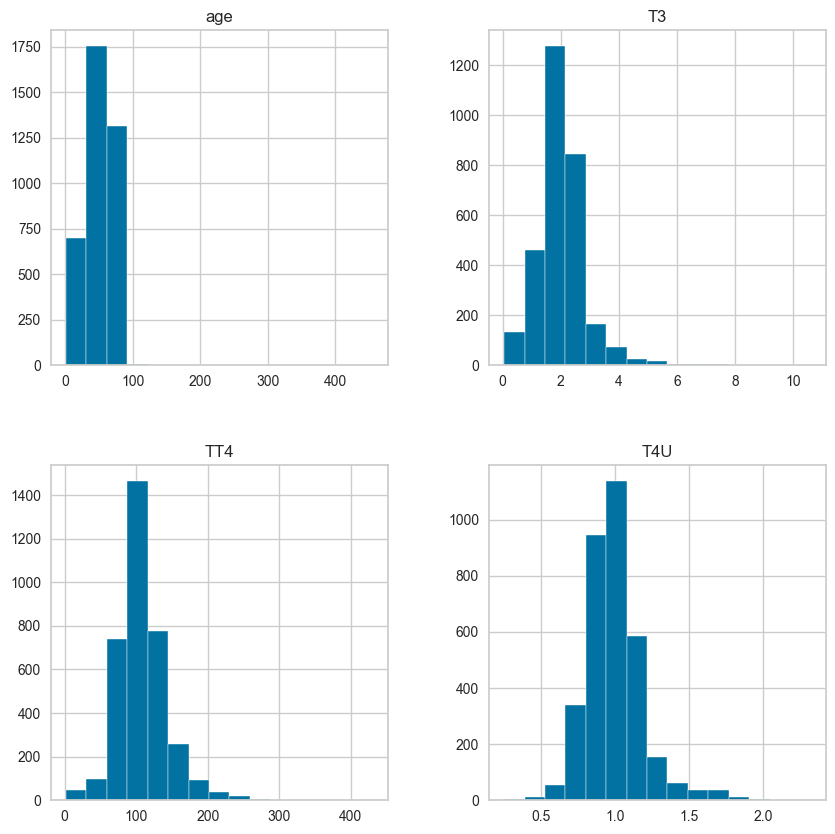

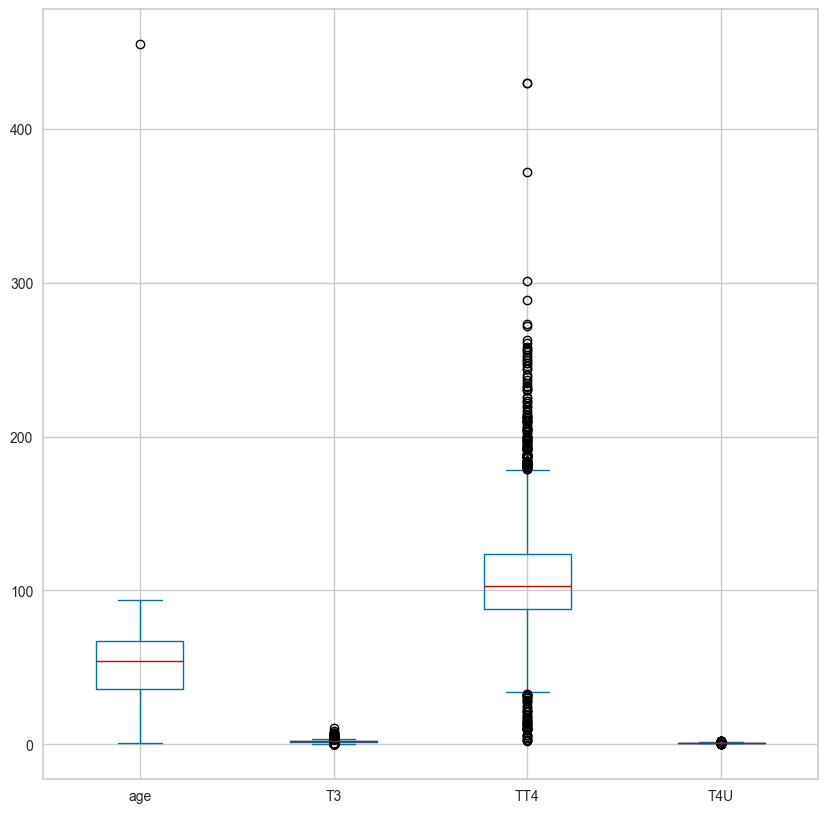

In [374]:
#Visualizamos algunos atributos
df.loc[:,['age', 'T3', 'TT4', 'T4U']].hist(bins=15, figsize=(10,10))

#Comprobamos si las variables numéricas siguen una distribución Normal.
print(normaltest(df['age'], nan_policy='omit'))
print(normaltest(df['T3'], nan_policy='omit'))


df.loc[:,['age', 'T3', 'TT4', 'T4U']].plot.box(figsize=(10,10));

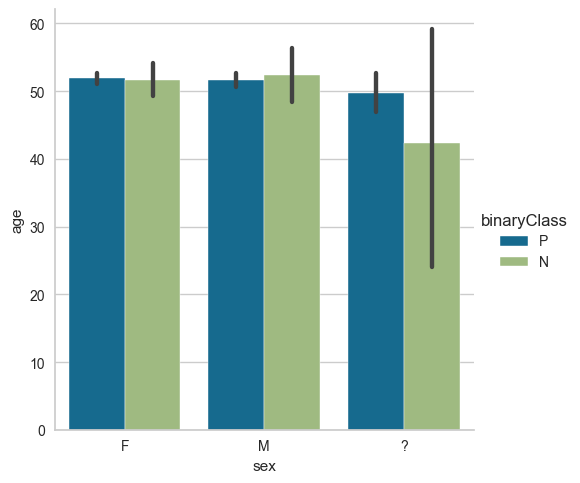

In [375]:
grafic = sns.catplot(data=df, kind="bar", x="sex", y="age", hue="binaryClass")

/tmp/ipykernel_27206/3035620522.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


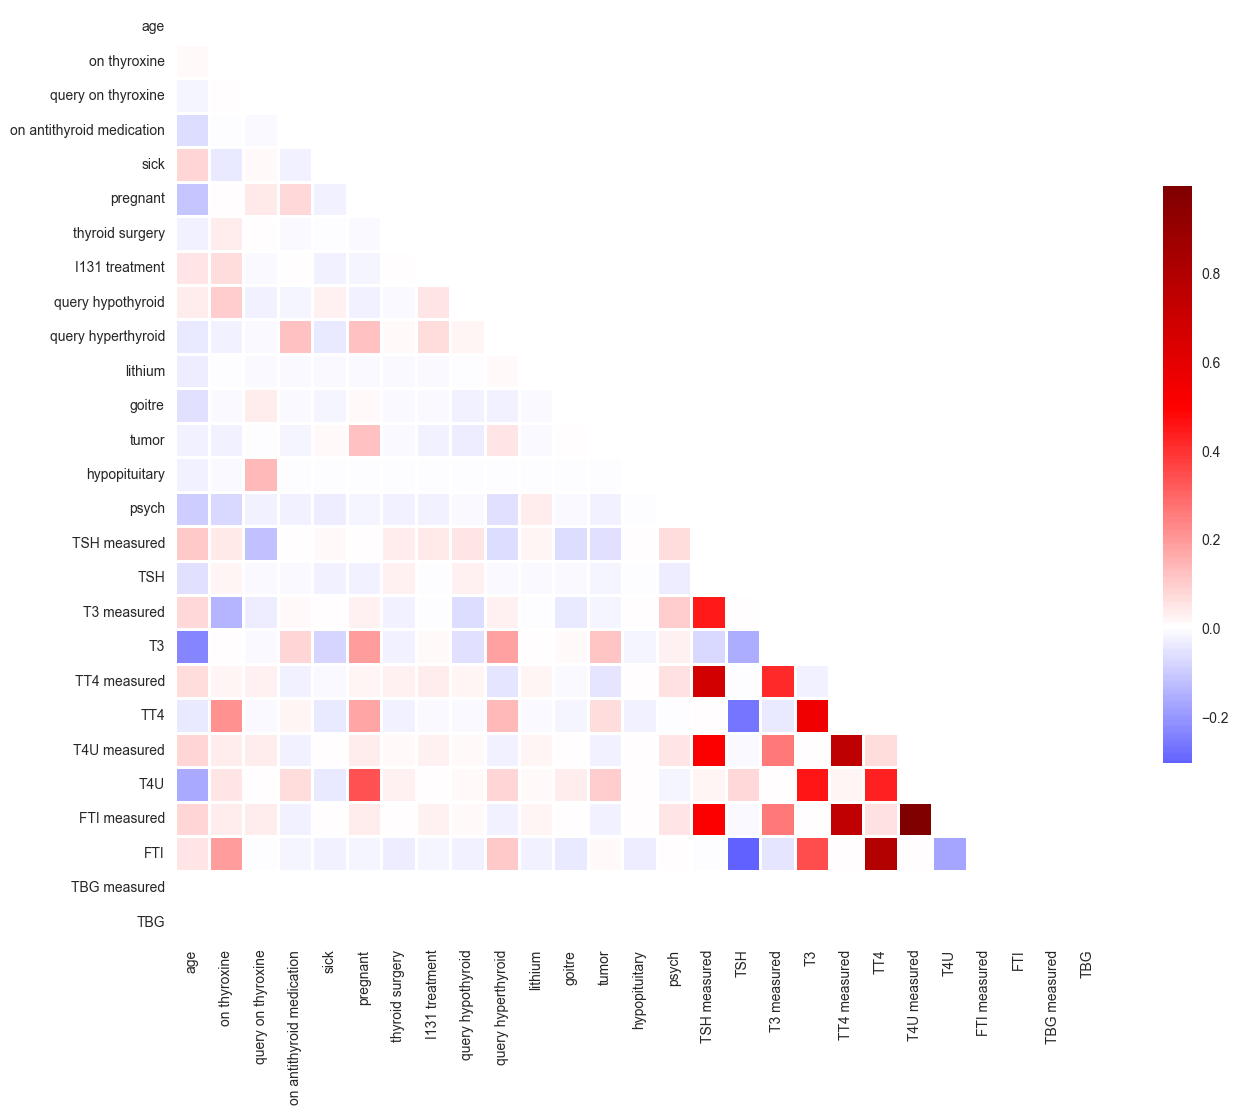

In [376]:
#Correlación entre distintas variables
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.8, cbar_kws={"shrink": .5});

#### Partición del Dataset

In [377]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train.shape, df_test.shape

((3017, 30), (755, 30))

#### Preprocesamiento del Dataset

In [378]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017 entries, 2661 to 3174
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3017 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3017 non-null   object 
 3   on thyroxine               3017 non-null   int64  
 4   query on thyroxine         3017 non-null   int64  
 5   on antithyroid medication  3017 non-null   int64  
 6   sick                       3017 non-null   int64  
 7   pregnant                   3017 non-null   int64  
 8   thyroid surgery            3017 non-null   int64  
 9   I131 treatment             3017 non-null   int64  
 10  query hypothyroid          3017 non-null   int64  
 11  query hyperthyroid         3017 non-null   int64  
 12  lithium                    3017 non-null   int64  
 13  goitre                     3017 non-null   in

In [379]:
#Contamos cuantos valores perdidos con NaN tenemos:
df_train.isna().sum()

binaryClass                     0
age                             1
sex                             0
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           297
T3 measured                     0
T3                            609
TT4 measured                    0
TT4                           184
T4U measured                    0
T4U                           310
FTI measured                    0
FTI                           308
TBG measured                    0
TBG                          3017
referral sourc

<AxesSubplot: >

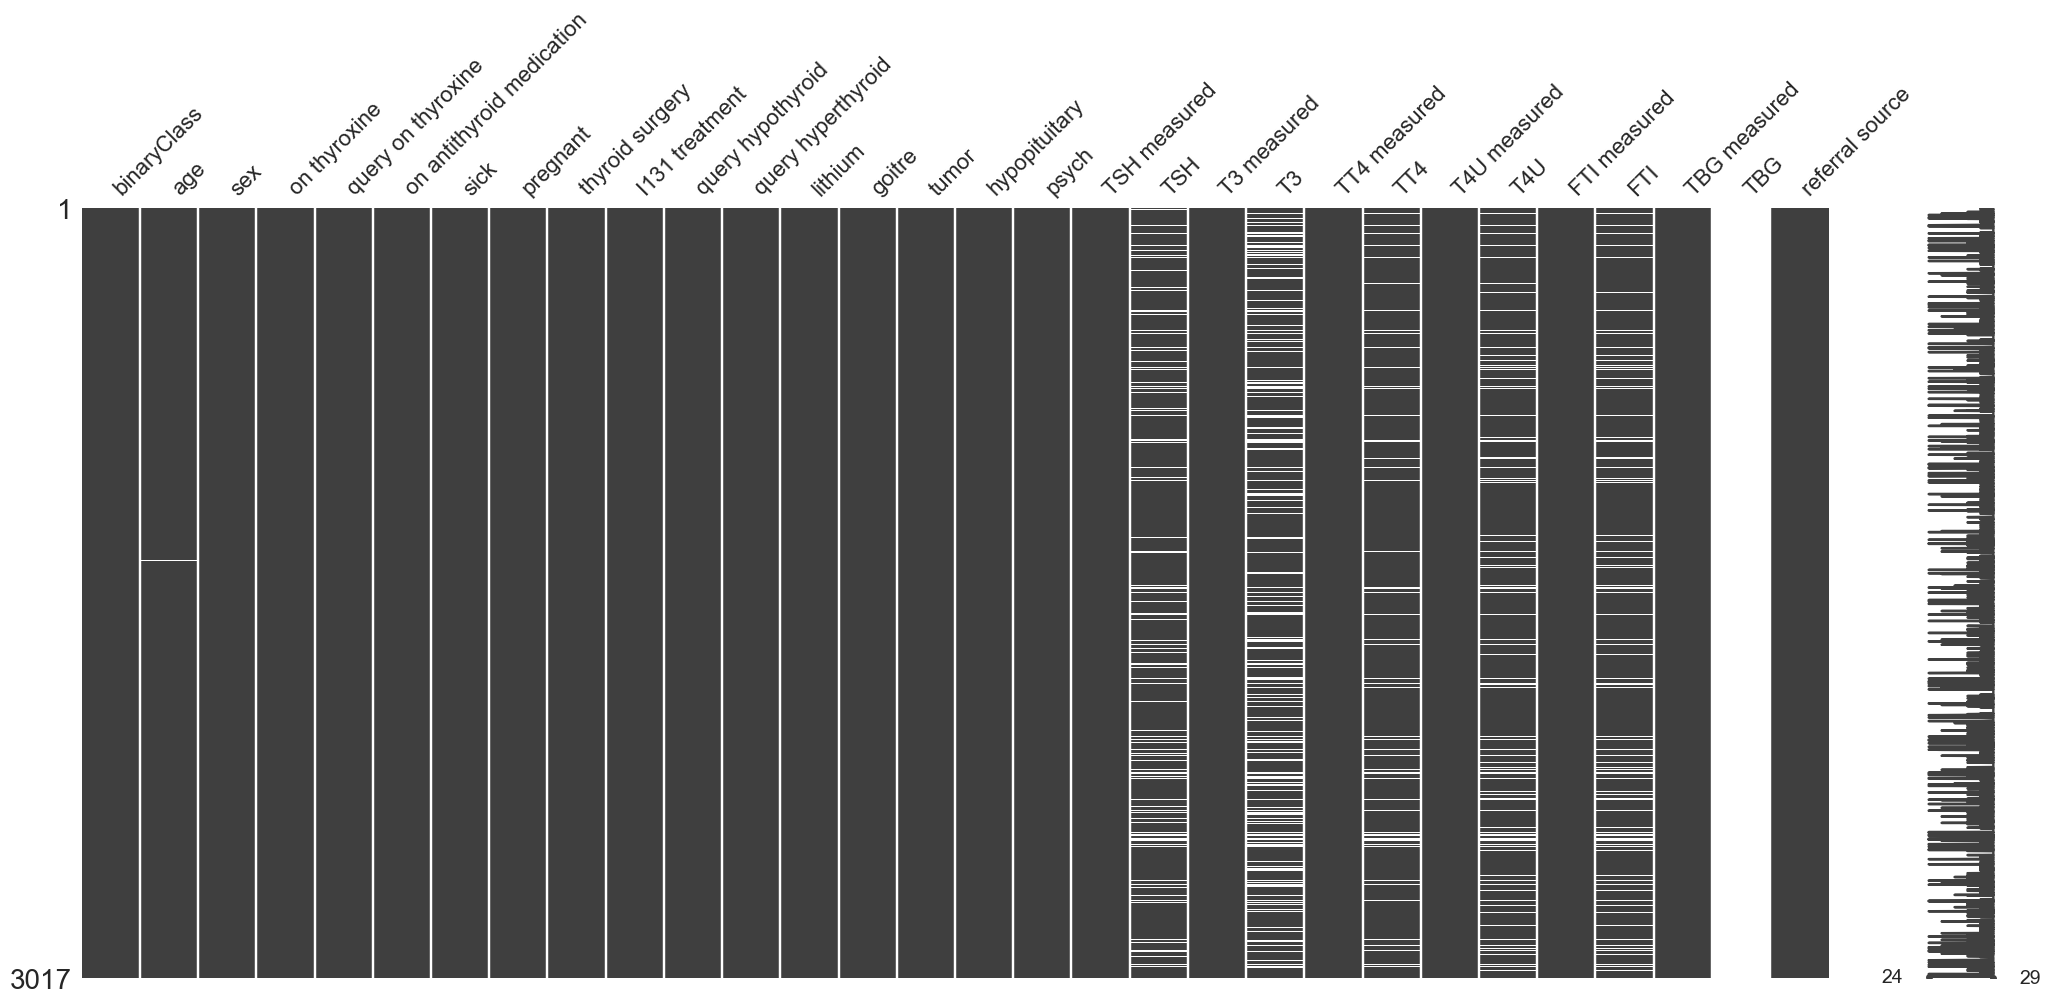

In [380]:
msno.matrix(df_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 2661 to 3174
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   object 
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   in

/tmp/ipykernel_27206/869975292.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train[~(small_outliers | big_outliers)].boxplot(column='age',ax=axes[0])
/tmp/ipykernel_27206/869975292.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train[~(small_outliers | big_outliers)]['age'].plot.kde().set_xlim(left=-10)


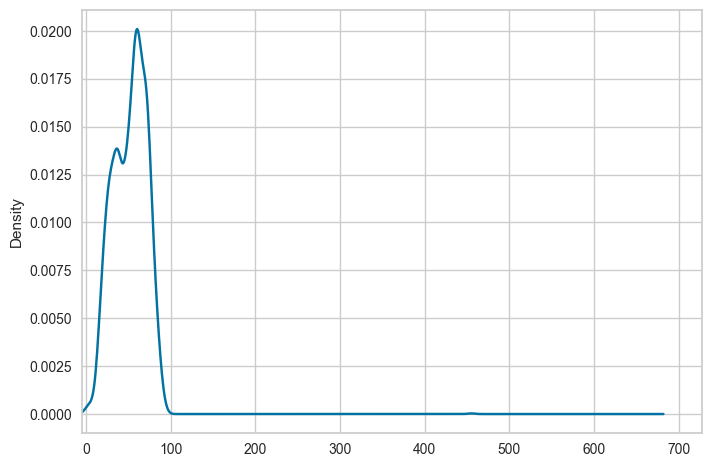

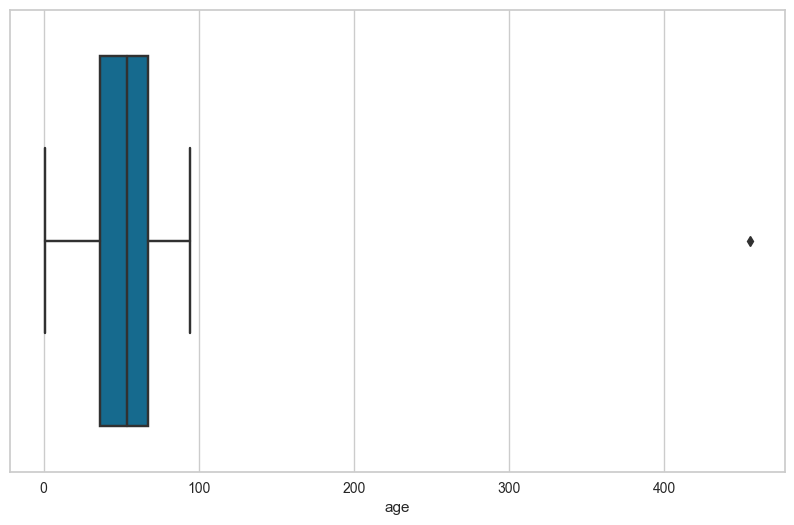

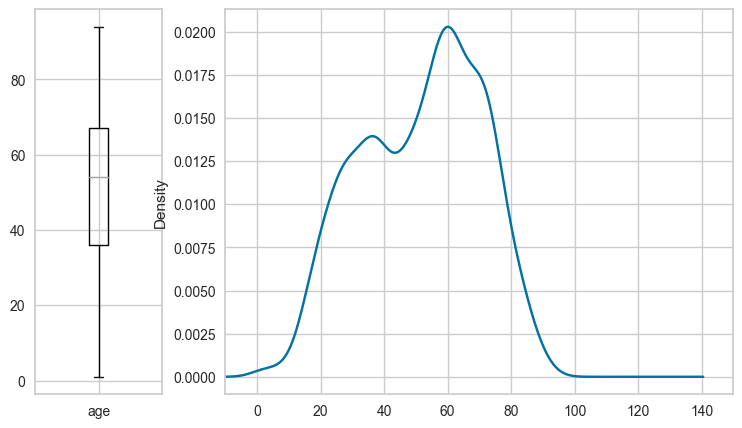

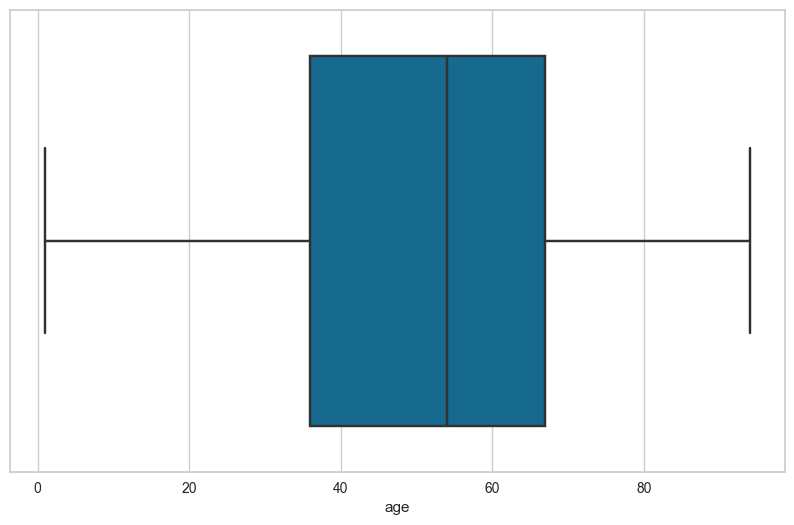

In [381]:
#Hemos de tratar los atributos:binaryClass, age, sex, TSH, T3, T4U, TT4, FTI, TBG y referral source

#age
df_train['age'].plot.kde().set_xlim(left=-5)
df_train['age'].mean()
df_train['age'].std()

df_train['age'].fillna(value=df_train['age'].mean(), inplace=True)

#outlier detectado en la columna de age, quitamos la fila del outlier:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_train, x="age")

Q1 = df_train['age'].quantile(0.25)
Q3 = df_train['age'].quantile(0.75)
IQR = Q3 - Q1

# Q1, Q3, IQR

small_outliers = df_train['age'] < (Q1 - 1.5 * IQR)
big_outliers = df_train['age'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

df_train['age'] [small_outliers | big_outliers].head()
df_train.drop([1364], inplace=True)
df_train.info()

#quitamos los outliers
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df_train[~(small_outliers | big_outliers)].boxplot(column='age',ax=axes[0])
df_train[~(small_outliers | big_outliers)]['age'].plot.kde().set_xlim(left=-10)

df_train['age'].mean()
df_train['age'].std()

#Lo hemos quitado exitosamente
plt.figure(figsize=(10,6))
sns.boxplot(data=df_train, x="age");

In [382]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 2661 to 3174
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   object 
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   in

In [383]:
df_train.isna().sum()

binaryClass                     0
age                             0
sex                             0
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           297
T3 measured                     0
T3                            609
TT4 measured                    0
TT4                           184
T4U measured                    0
T4U                           310
FTI measured                    0
FTI                           308
TBG measured                    0
TBG                          3016
referral sourc

In [384]:
#tratamos la columna TBG
df_train.drop('TBG', inplace=True, axis=1)
df_train.info()
df_train.isna().sum()

#tratamos la columna referral source
df_train.drop('referral source', inplace=True, axis=1)
df_train.info()
df_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 2661 to 3174
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   object 
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   in

binaryClass                    0
age                            0
sex                            0
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                          297
T3 measured                    0
T3                           609
TT4 measured                   0
TT4                          184
T4U measured                   0
T4U                          310
FTI measured                   0
FTI                          308
TBG measured                   0
referral source                0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 2661 to 3174
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   object 
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   in

binaryClass                    0
age                            0
sex                            0
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                          297
T3 measured                    0
T3                           609
TT4 measured                   0
TT4                          184
T4U measured                   0
T4U                          310
FTI measured                   0
FTI                          308
TBG measured                   0
dtype: int64

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'on thyroxine'}>,
        <AxesSubplot: title={'center': 'query on thyroxine'}>,
        <AxesSubplot: title={'center': 'on antithyroid medication'}>,
        <AxesSubplot: title={'center': 'sick'}>],
       [<AxesSubplot: title={'center': 'pregnant'}>,
        <AxesSubplot: title={'center': 'thyroid surgery'}>,
        <AxesSubplot: title={'center': 'I131 treatment'}>,
        <AxesSubplot: title={'center': 'query hypothyroid'}>,
        <AxesSubplot: title={'center': 'query hyperthyroid'}>],
       [<AxesSubplot: title={'center': 'lithium'}>,
        <AxesSubplot: title={'center': 'goitre'}>,
        <AxesSubplot: title={'center': 'tumor'}>,
        <AxesSubplot: title={'center': 'hypopituitary'}>,
        <AxesSubplot: title={'center': 'psych'}>],
       [<AxesSubplot: title={'center': 'TSH measured'}>,
        <AxesSubplot: title={'center': 'TSH'}>,
        <AxesSubplot: title={'center': 'T3 meas

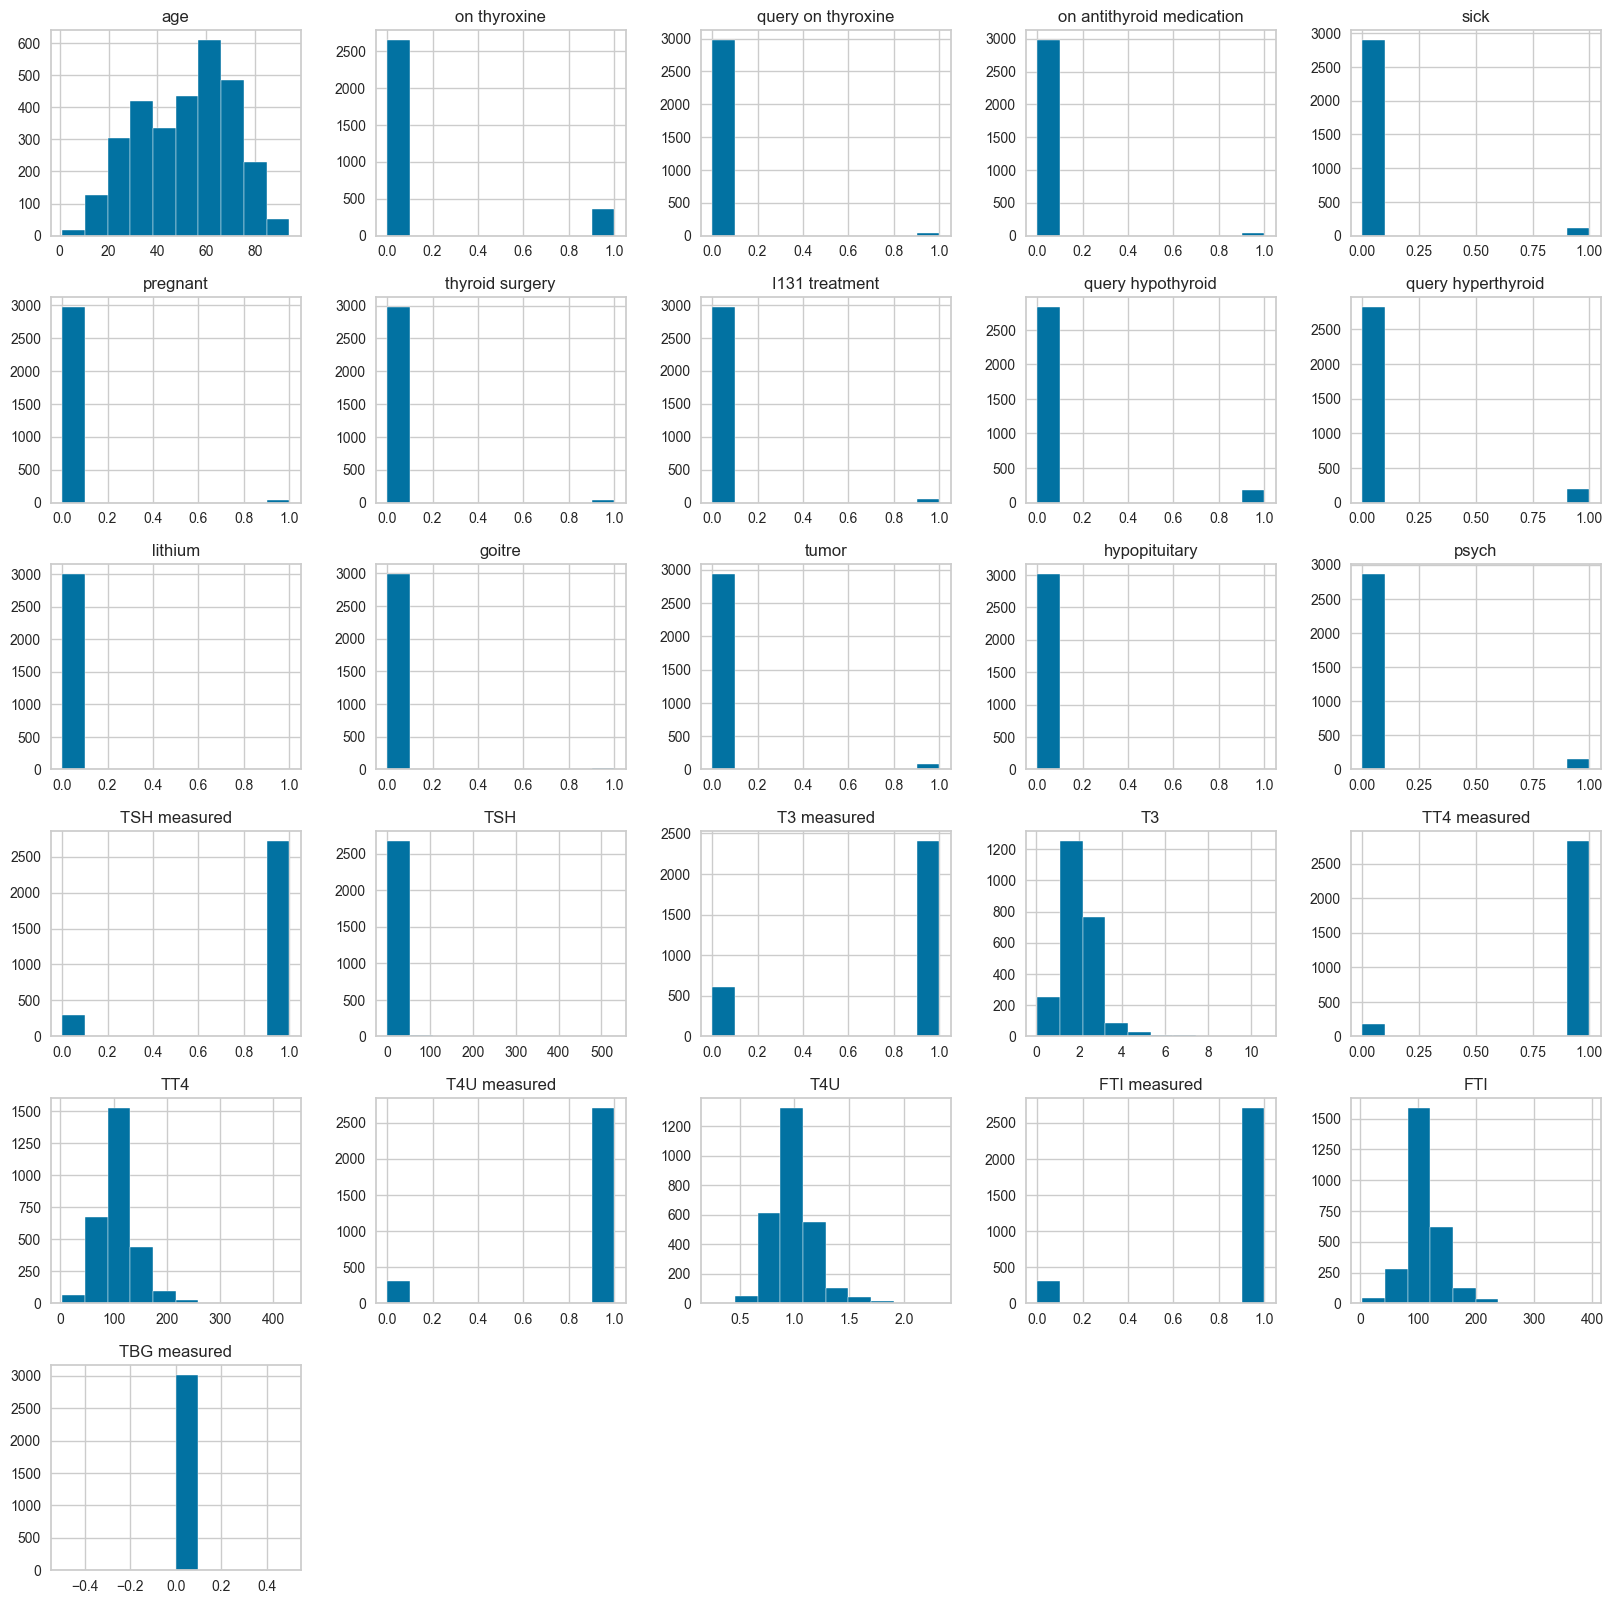

In [385]:
df_train.hist(figsize = (20,20))

In [386]:
df_train.describe()

,age,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,...,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured
count,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,...,2719.000000,3016.000000,2407.000000,3016.000000,2832.000000,3016.000000,2706.000000,3016.000000,2708.000000,3016.0
mean,51.601039,0.121021,0.012931,0.011605,0.039125,0.012931,0.012599,0.015584,0.061008,0.063660,...,5.063284,0.798077,2.013336,0.938992,108.431815,0.897215,0.993996,0.897878,110.629247,0.0
std,18.952459,0.326206,0.112996,0.107116,0.193924,0.112996,0.111556,0.123878,0.239385,0.244188,...,24.526872,0.401502,0.831512,0.239385,35.950941,0.303728,0.192990,0.302859,33.367757,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005000,0.000000,0.050000,0.000000,3.000000,0.000000,0.250000,0.000000,3.000000,0.0
25%,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.485000,1.000000,1.600000,1.000000,87.750000,1.000000,0.880000,1.000000,93.000000,0.0
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.400000,1.000000,2.000000,1.000000,103.000000,1.000000,0.970000,1.000000,107.000000,0.0
75%,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.700000,1.000000,2.300000,1.000000,124.000000,1.000000,1.080000,1.000000,124.000000,0.0
max,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,530.000000,1.000000,10.600000,1.000000,430.000000,1.000000,2.320000,1.000000,395.000000,0.0


In [387]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 2661 to 3174
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   object 
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   in

In [388]:
#convertimos la variable de 'sex'
df_train['sex'].unique()
df_train['sex'].value_counts()

#La categoria ? nos muestra que no sabemos el sexo del paciente asi que supondremos que es una mujer ya que tenemos un valor para esta categoria mayor
df_train.replace(to_replace='?', inplace=True, value='F')
df_train['sex'] = df_train['sex'].astype('category').cat.codes

df_train['sex'].unique()
df_train['sex'].value_counts()

array(['F', 'M', '?'], dtype=object)

F    1977
M     916
?     123
Name: sex, dtype: int64

array([0, 1], dtype=int8)

0    2100
1     916
Name: sex, dtype: int64

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'sex'}>,
        <AxesSubplot: title={'center': 'on thyroxine'}>,
        <AxesSubplot: title={'center': 'query on thyroxine'}>,
        <AxesSubplot: title={'center': 'on antithyroid medication'}>],
       [<AxesSubplot: title={'center': 'sick'}>,
        <AxesSubplot: title={'center': 'pregnant'}>,
        <AxesSubplot: title={'center': 'thyroid surgery'}>,
        <AxesSubplot: title={'center': 'I131 treatment'}>,
        <AxesSubplot: title={'center': 'query hypothyroid'}>],
       [<AxesSubplot: title={'center': 'query hyperthyroid'}>,
        <AxesSubplot: title={'center': 'lithium'}>,
        <AxesSubplot: title={'center': 'goitre'}>,
        <AxesSubplot: title={'center': 'tumor'}>,
        <AxesSubplot: title={'center': 'hypopituitary'}>],
       [<AxesSubplot: title={'center': 'psych'}>,
        <AxesSubplot: title={'center': 'TSH measured'}>,
        <AxesSubplot: title={'center': 'TSH'}>,

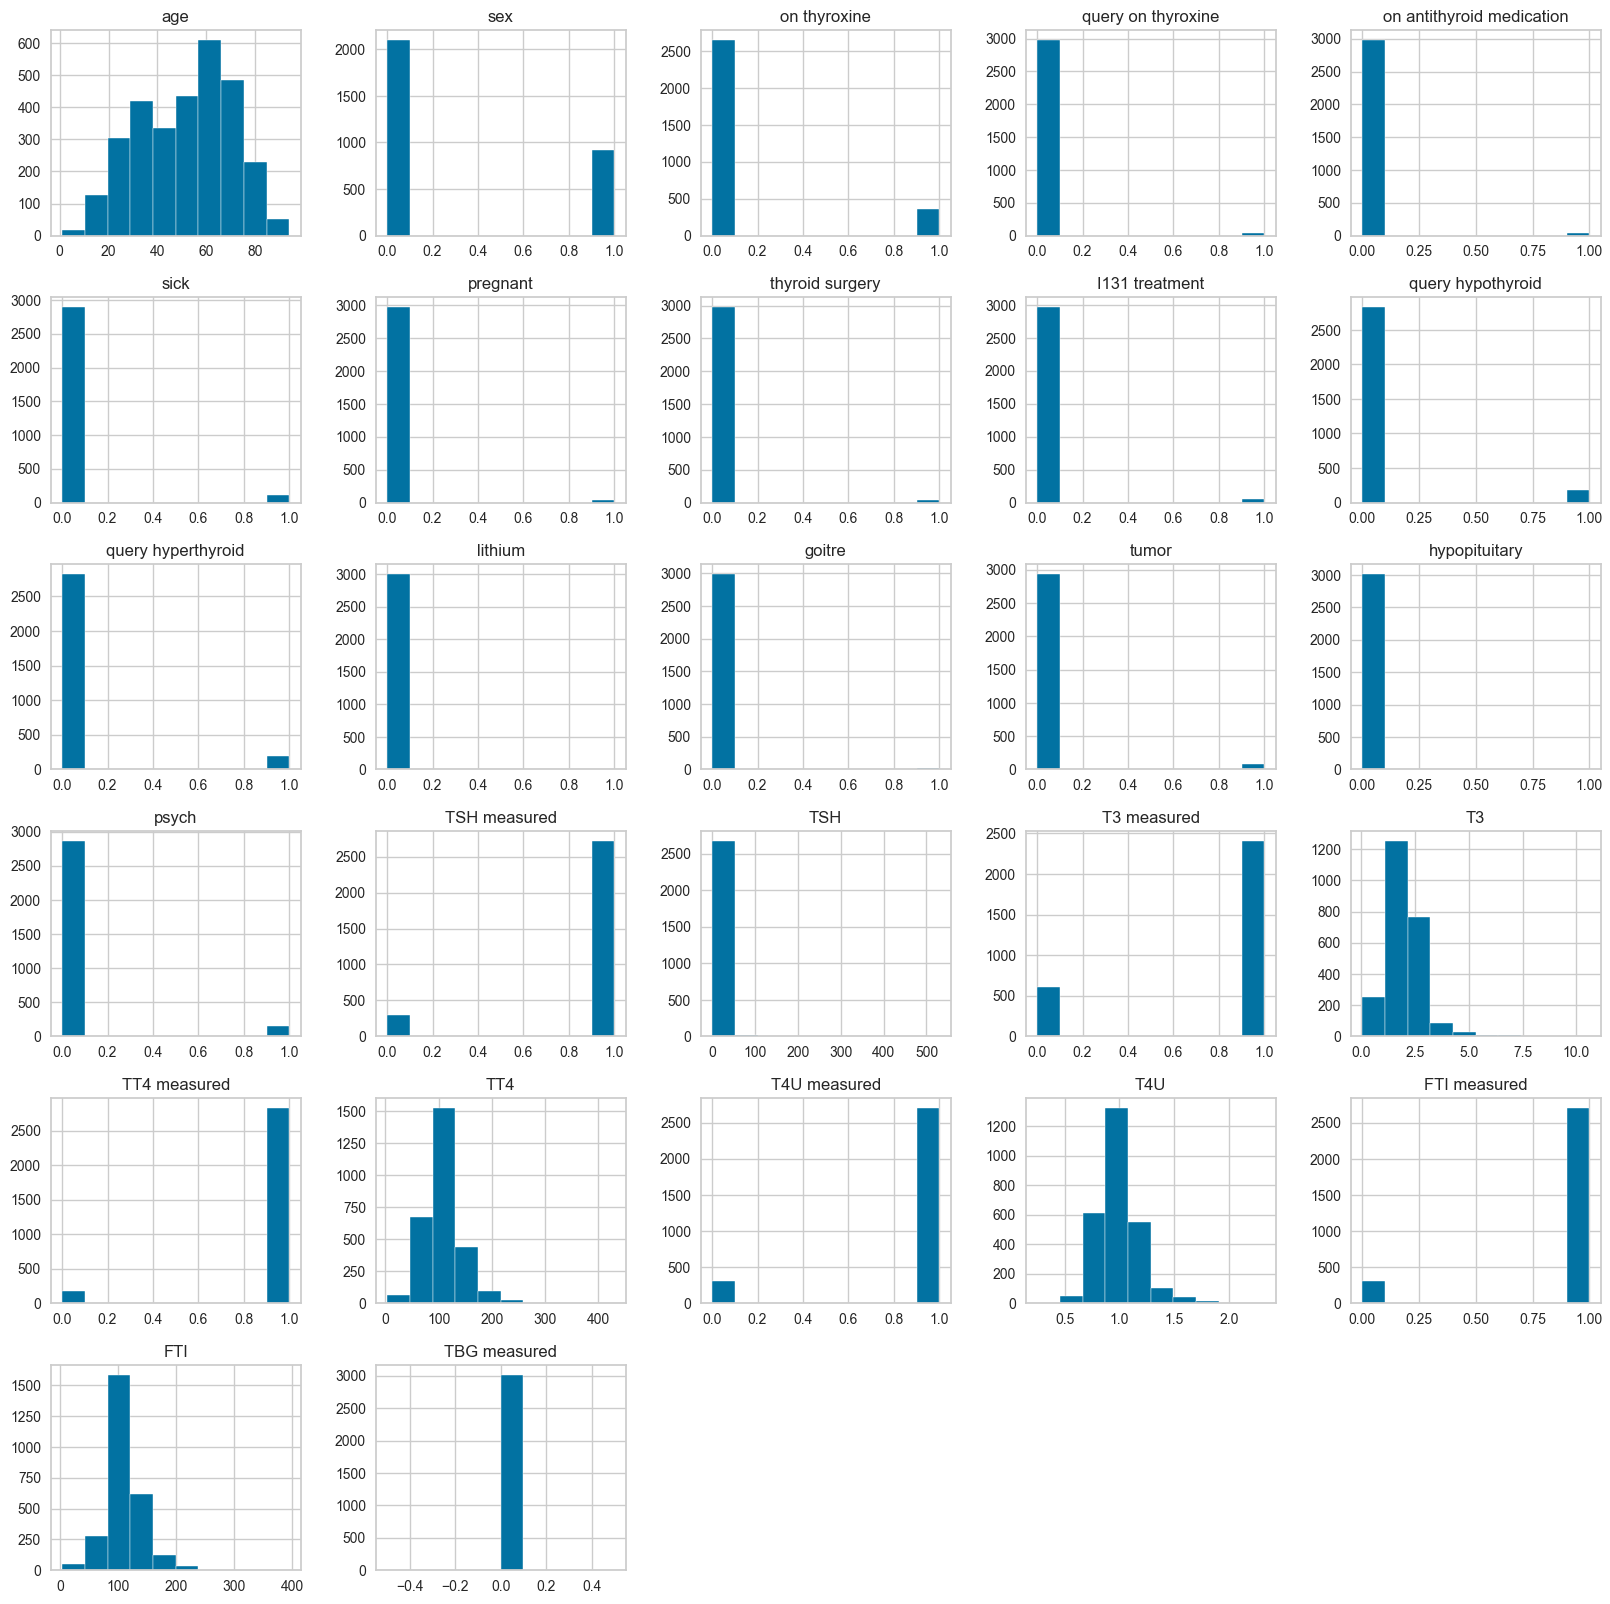

In [389]:
df_train.hist(figsize = (20,20))

In [390]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 2661 to 3174
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   object 
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   int8   
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   in

In [391]:
#convertimos la variable respuesta a binaria
df_train['binaryClass'].unique()
df_train['binaryClass'].value_counts()

df_train['binaryClass'] = df_train['binaryClass'].astype('category').cat.codes

df_train.info()

array(['P', 'N'], dtype=object)

P    2783
N     233
Name: binaryClass, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 2661 to 3174
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                3016 non-null   int8   
 1   age                        3016 non-null   float64
 2   sex                        3016 non-null   int8   
 3   on thyroxine               3016 non-null   int64  
 4   query on thyroxine         3016 non-null   int64  
 5   on antithyroid medication  3016 non-null   int64  
 6   sick                       3016 non-null   int64  
 7   pregnant                   3016 non-null   int64  
 8   thyroid surgery            3016 non-null   int64  
 9   I131 treatment             3016 non-null   int64  
 10  query hypothyroid          3016 non-null   int64  
 11  query hyperthyroid         3016 non-null   int64  
 12  lithium                    3016 non-null   int64  
 13  goitre                     3016 non-null   in

In [392]:
df_train.describe()

,binaryClass,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,...,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured
count,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,...,2719.000000,3016.000000,2407.000000,3016.000000,2832.000000,3016.000000,2706.000000,3016.000000,2708.000000,3016.0
mean,0.922745,51.601039,0.303714,0.121021,0.012931,0.011605,0.039125,0.012931,0.012599,0.015584,...,5.063284,0.798077,2.013336,0.938992,108.431815,0.897215,0.993996,0.897878,110.629247,0.0
std,0.267039,18.952459,0.459937,0.326206,0.112996,0.107116,0.193924,0.112996,0.111556,0.123878,...,24.526872,0.401502,0.831512,0.239385,35.950941,0.303728,0.192990,0.302859,33.367757,0.0
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005000,0.000000,0.050000,0.000000,3.000000,0.000000,0.250000,0.000000,3.000000,0.0
25%,1.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.485000,1.000000,1.600000,1.000000,87.750000,1.000000,0.880000,1.000000,93.000000,0.0
50%,1.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.400000,1.000000,2.000000,1.000000,103.000000,1.000000,0.970000,1.000000,107.000000,0.0
75%,1.000000,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.700000,1.000000,2.300000,1.000000,124.000000,1.000000,1.080000,1.000000,124.000000,0.0
max,1.000000,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,530.000000,1.000000,10.600000,1.000000,430.000000,1.000000,2.320000,1.000000,395.000000,0.0


array([[<AxesSubplot: title={'center': 'binaryClass'}>,
        <AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'sex'}>,
        <AxesSubplot: title={'center': 'on thyroxine'}>,
        <AxesSubplot: title={'center': 'query on thyroxine'}>],
       [<AxesSubplot: title={'center': 'on antithyroid medication'}>,
        <AxesSubplot: title={'center': 'sick'}>,
        <AxesSubplot: title={'center': 'pregnant'}>,
        <AxesSubplot: title={'center': 'thyroid surgery'}>,
        <AxesSubplot: title={'center': 'I131 treatment'}>],
       [<AxesSubplot: title={'center': 'query hypothyroid'}>,
        <AxesSubplot: title={'center': 'query hyperthyroid'}>,
        <AxesSubplot: title={'center': 'lithium'}>,
        <AxesSubplot: title={'center': 'goitre'}>,
        <AxesSubplot: title={'center': 'tumor'}>],
       [<AxesSubplot: title={'center': 'hypopituitary'}>,
        <AxesSubplot: title={'center': 'psych'}>,
        <AxesSubplot: title={'center': 'TSH meas

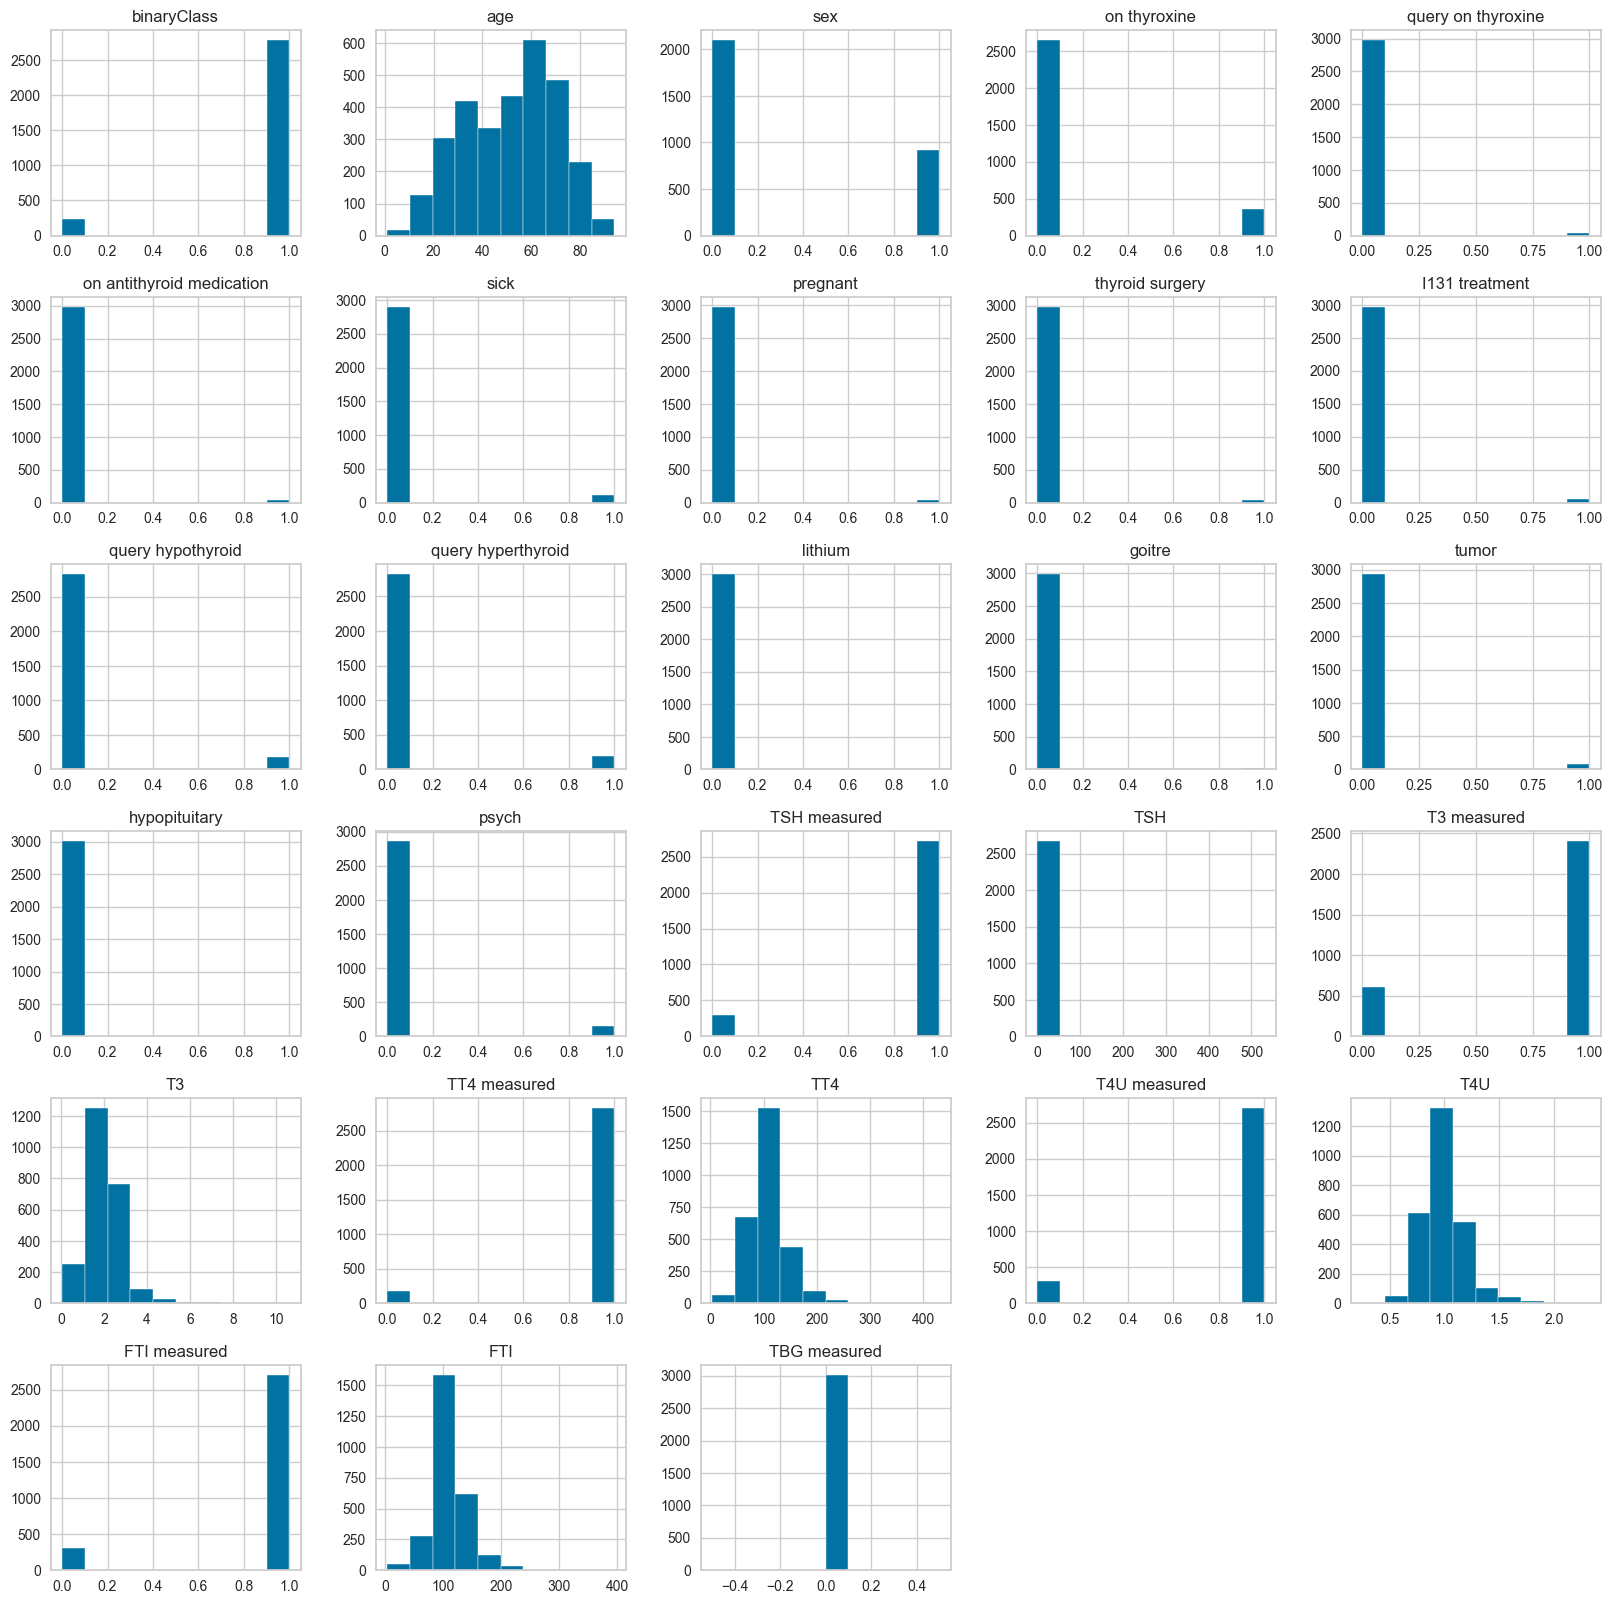

In [393]:
df_train.hist(figsize = (20,20))

In [394]:
#encara ens falta tractar els atributs: TSH, T3, T4U, TT4, FTI, per ara els missing values els inferirem amb la mediana de cadascun d'ells
df_train['TSH'].fillna(value=df_train['TSH'].mean(), inplace = True)
df_train['T3'].fillna(value=df_train['age'].mean(), inplace = True)
df_train['TT4'].fillna(value=df_train['age'].mean(), inplace = True)
df_train['T4U'].fillna(value=df_train['age'].mean(), inplace = True)
df_train['FTI'].fillna(value=df_train['age'].mean(), inplace = True)

In [395]:
#vale ja hem netejat el conjunt d'entrenament
df_train.describe()
df_train.isna().sum()

,binaryClass,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,...,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured
count,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,...,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.000000,3016.0
mean,0.922745,51.601039,0.303714,0.121021,0.012931,0.011605,0.039125,0.012931,0.012599,0.015584,...,5.063284,0.798077,12.026238,0.938992,104.964685,0.897215,6.195649,0.897878,104.601167,0.0
std,0.267039,18.952459,0.459937,0.326206,0.112996,0.107116,0.193924,0.112996,0.111556,0.123878,...,23.287520,0.401502,19.923398,0.239385,37.398838,0.303728,15.371884,0.302859,36.321633,0.0
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005000,0.000000,0.050000,0.000000,3.000000,0.000000,0.250000,0.000000,3.000000,0.0
25%,1.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.600000,1.000000,1.700000,1.000000,84.000000,1.000000,0.890000,1.000000,86.000000,0.0
50%,1.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.600000,1.000000,2.200000,1.000000,101.000000,1.000000,1.000000,1.000000,104.000000,0.0
75%,1.000000,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.800000,1.000000,3.200000,1.000000,123.000000,1.000000,1.140000,1.000000,122.000000,0.0
max,1.000000,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,530.000000,1.000000,51.601039,1.000000,430.000000,1.000000,51.601039,1.000000,395.000000,0.0


binaryClass                  0
age                          0
sex                          0
on thyroxine                 0
query on thyroxine           0
on antithyroid medication    0
sick                         0
pregnant                     0
thyroid surgery              0
I131 treatment               0
query hypothyroid            0
query hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH measured                 0
TSH                          0
T3 measured                  0
T3                           0
TT4 measured                 0
TT4                          0
T4U measured                 0
T4U                          0
FTI measured                 0
FTI                          0
TBG measured                 0
dtype: int64

#### Preprocesamiento del conjunto de test

In [396]:
df_test.isna().sum()
df_test.info()

binaryClass                    0
age                            0
sex                            0
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                           72
T3 measured                    0
T3                           160
TT4 measured                   0
TT4                           47
T4U measured                   0
T4U                           77
FTI measured                   0
FTI                           77
TBG measured                   0
TBG                          755
referral source                0
dtype: int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 270 to 543
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                755 non-null    object 
 1   age                        755 non-null    float64
 2   sex                        755 non-null    object 
 3   on thyroxine               755 non-null    int64  
 4   query on thyroxine         755 non-null    int64  
 5   on antithyroid medication  755 non-null    int64  
 6   sick                       755 non-null    int64  
 7   pregnant                   755 non-null    int64  
 8   thyroid surgery            755 non-null    int64  
 9   I131 treatment             755 non-null    int64  
 10  query hypothyroid          755 non-null    int64  
 11  query hyperthyroid         755 non-null    int64  
 12  lithium                    755 non-null    int64  
 13  goitre                     755 non-null    int64

In [397]:
#quitamos referral source, convertimos la variable 'sex' y binaryClass
#tratamos la columna referral source
df_test.drop('TBG', inplace=True, axis=1)
df_test.drop('referral source', inplace=True, axis=1)

#convertimos la variable de 'sex'
df_test['sex'].unique()
df_test['sex'].value_counts()

#La categoria ? nos muestra que no sabemos el sexo del paciente asi que supondremos que es una mujer ya que tenemos un valor para esta categoria mayor
df_test.replace(to_replace='?', inplace=True, value='F')
df_test['sex'] = df_test['sex'].astype('category').cat.codes

df_test['sex'].unique()
df_test['sex'].value_counts()

df_test['binaryClass'].unique()
df_test['binaryClass'].value_counts()

df_test['binaryClass'] = df_test['binaryClass'].astype('category').cat.codes

#modificamos los nan que quedan de los atributos que son proteinas
df_test['TSH'].fillna(value=df_test['TSH'].mean(), inplace = True)
df_test['T3'].fillna(value=df_test['age'].mean(), inplace = True)
df_test['TT4'].fillna(value=df_test['age'].mean(), inplace = True)
df_test['T4U'].fillna(value=df_test['age'].mean(), inplace = True)
df_test['FTI'].fillna(value=df_test['age'].mean(), inplace = True)

df_test.info()

array(['F', 'M', '?'], dtype=object)

F    502
M    226
?     27
Name: sex, dtype: int64

array([0, 1], dtype=int8)

0    529
1    226
Name: sex, dtype: int64

array(['P', 'N'], dtype=object)

P    697
N     58
Name: binaryClass, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 270 to 543
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   binaryClass                755 non-null    int8   
 1   age                        755 non-null    float64
 2   sex                        755 non-null    int8   
 3   on thyroxine               755 non-null    int64  
 4   query on thyroxine         755 non-null    int64  
 5   on antithyroid medication  755 non-null    int64  
 6   sick                       755 non-null    int64  
 7   pregnant                   755 non-null    int64  
 8   thyroid surgery            755 non-null    int64  
 9   I131 treatment             755 non-null    int64  
 10  query hypothyroid          755 non-null    int64  
 11  query hyperthyroid         755 non-null    int64  
 12  lithium                    755 non-null    int64  
 13  goitre                     755 non-null    int64

array([[<AxesSubplot: title={'center': 'binaryClass'}>,
        <AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'sex'}>,
        <AxesSubplot: title={'center': 'on thyroxine'}>,
        <AxesSubplot: title={'center': 'query on thyroxine'}>],
       [<AxesSubplot: title={'center': 'on antithyroid medication'}>,
        <AxesSubplot: title={'center': 'sick'}>,
        <AxesSubplot: title={'center': 'pregnant'}>,
        <AxesSubplot: title={'center': 'thyroid surgery'}>,
        <AxesSubplot: title={'center': 'I131 treatment'}>],
       [<AxesSubplot: title={'center': 'query hypothyroid'}>,
        <AxesSubplot: title={'center': 'query hyperthyroid'}>,
        <AxesSubplot: title={'center': 'lithium'}>,
        <AxesSubplot: title={'center': 'goitre'}>,
        <AxesSubplot: title={'center': 'tumor'}>],
       [<AxesSubplot: title={'center': 'hypopituitary'}>,
        <AxesSubplot: title={'center': 'psych'}>,
        <AxesSubplot: title={'center': 'TSH meas

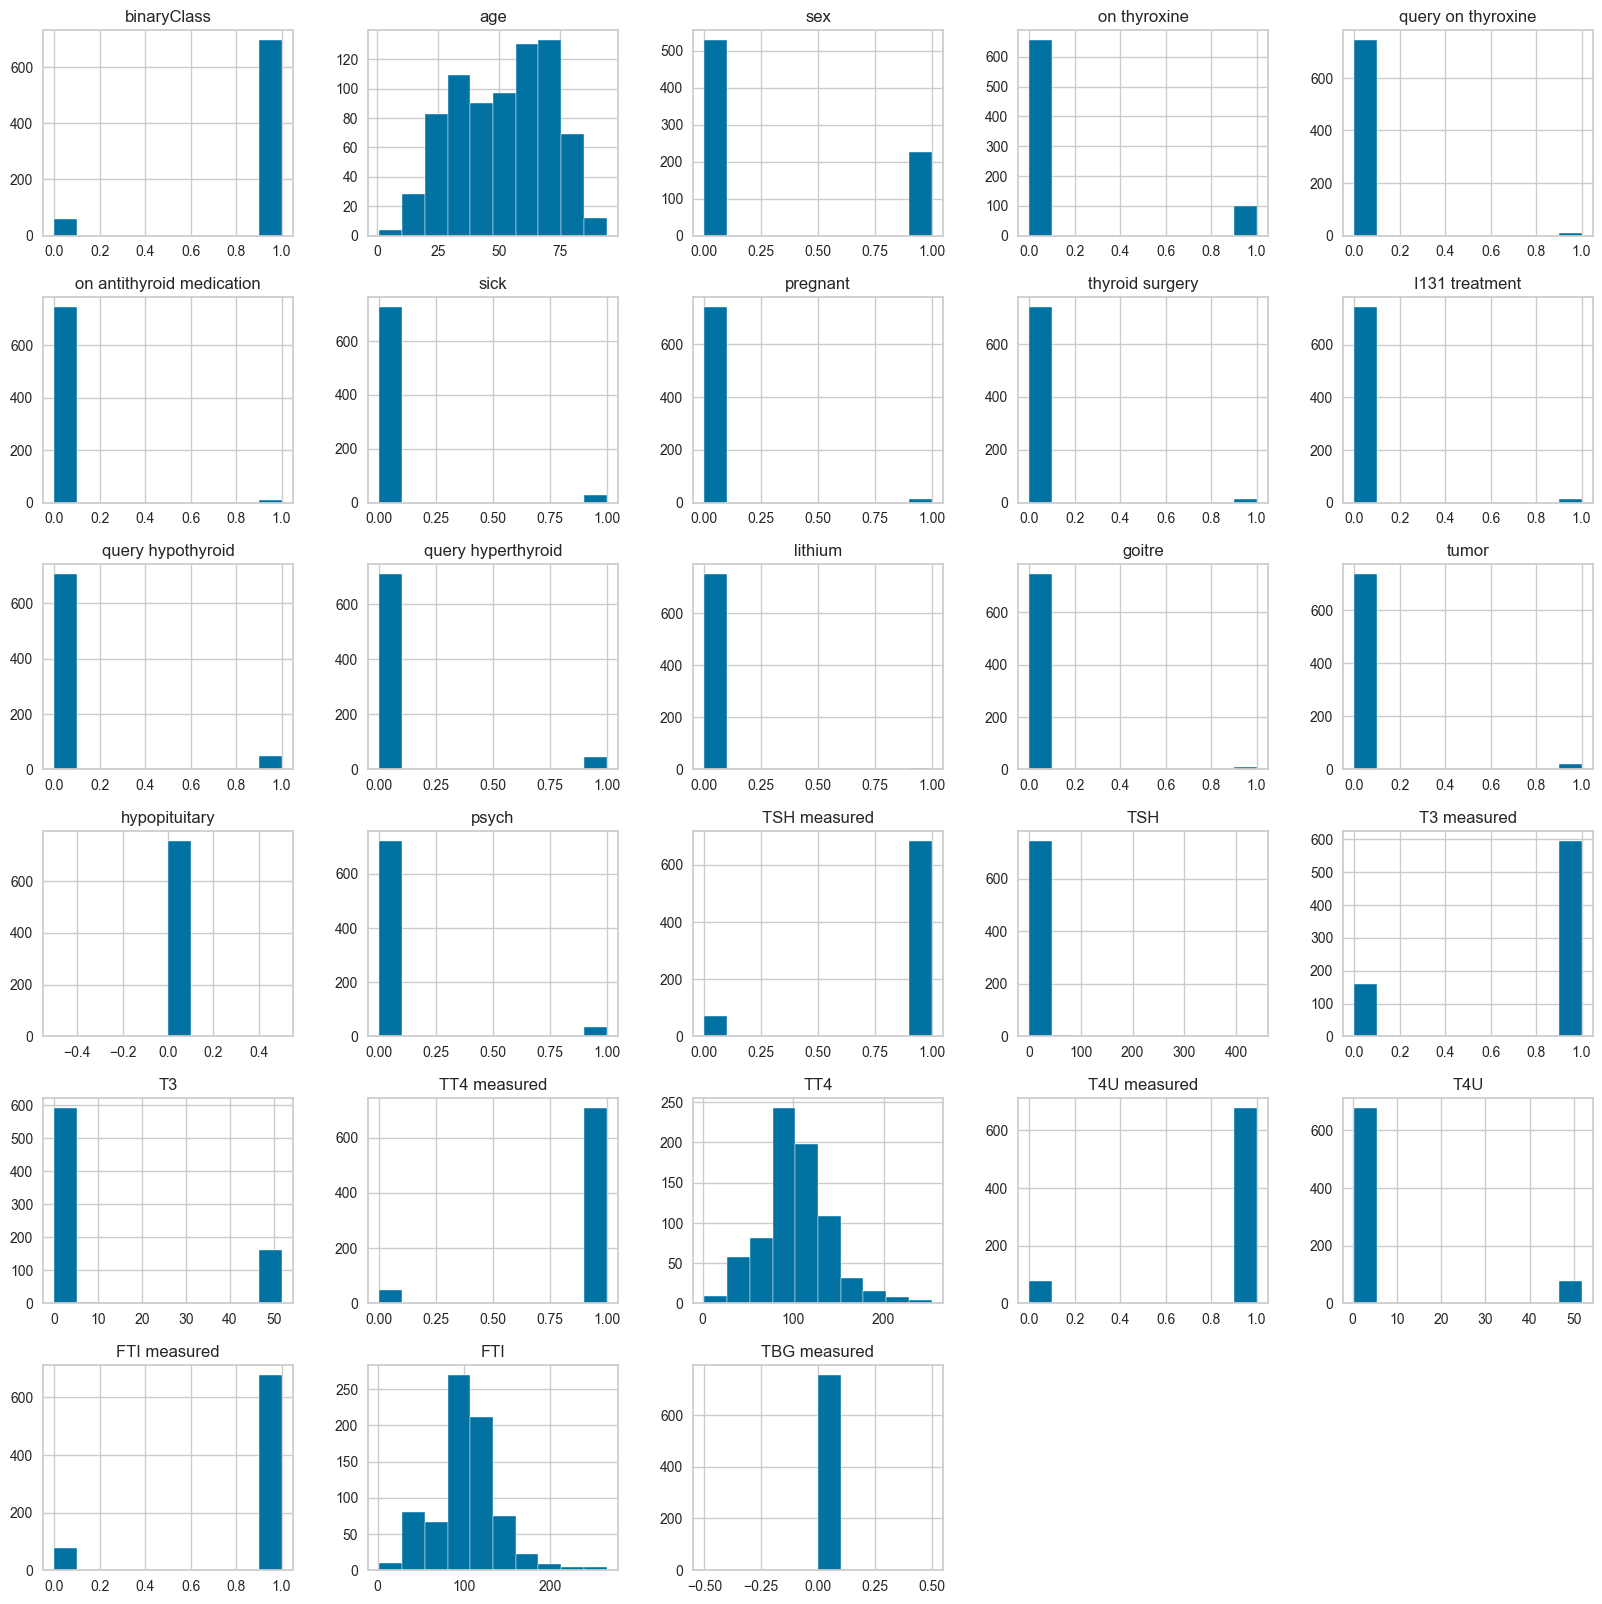

In [398]:
df_test.hist(figsize = (20,20))

In [399]:
#Guardem els datasets netejats a nous csv
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

## APLICACIÓN DE DISTINTOS MODELOS

In [400]:
#Conseguimos el csv de entrenamiento
X_train = read_csv('df_train.csv')
y_train = X_train['binaryClass']

X_train.drop('binaryClass', axis=1, inplace = True)

# X_train
# y_train

#Conseguimos el csv de test
X_test = read_csv('df_test.csv')
y_test = X_test['binaryClass']

X_test.drop('binaryClass', axis=1, inplace = True)

# X_test
# y_test

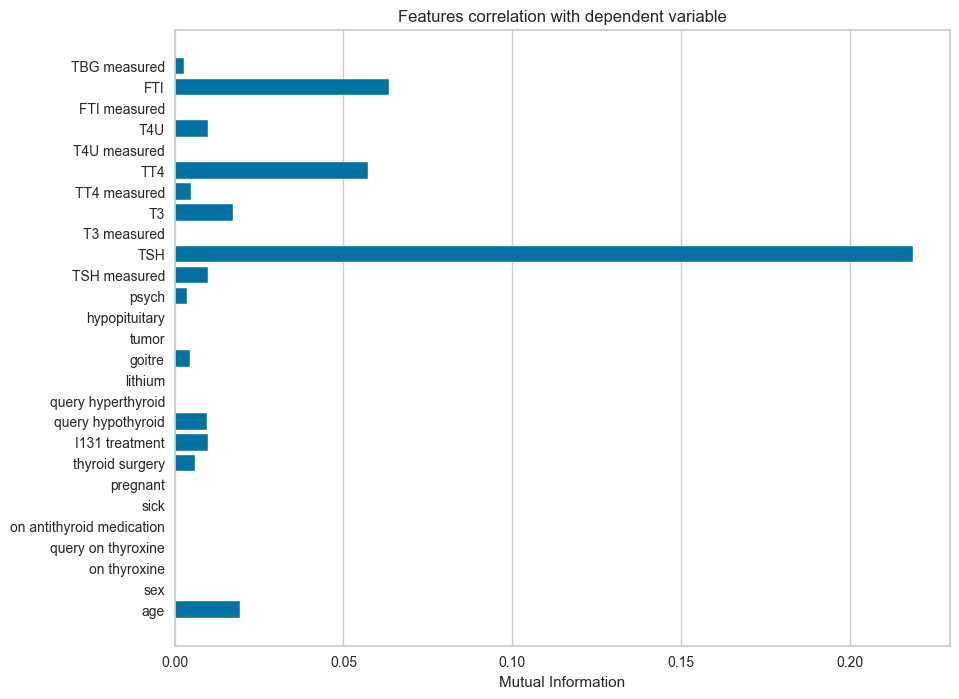

In [401]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train, y_train, labels=list(X_train.columns),method='mutual_info-classification');

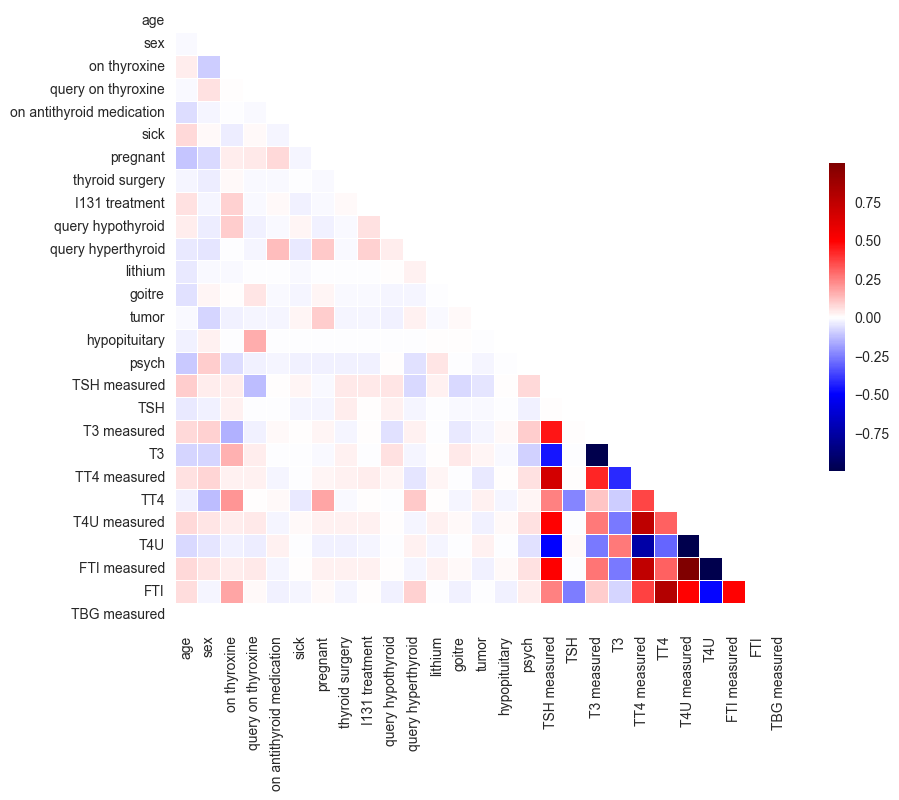

In [402]:
corr = X_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

/home/pol/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


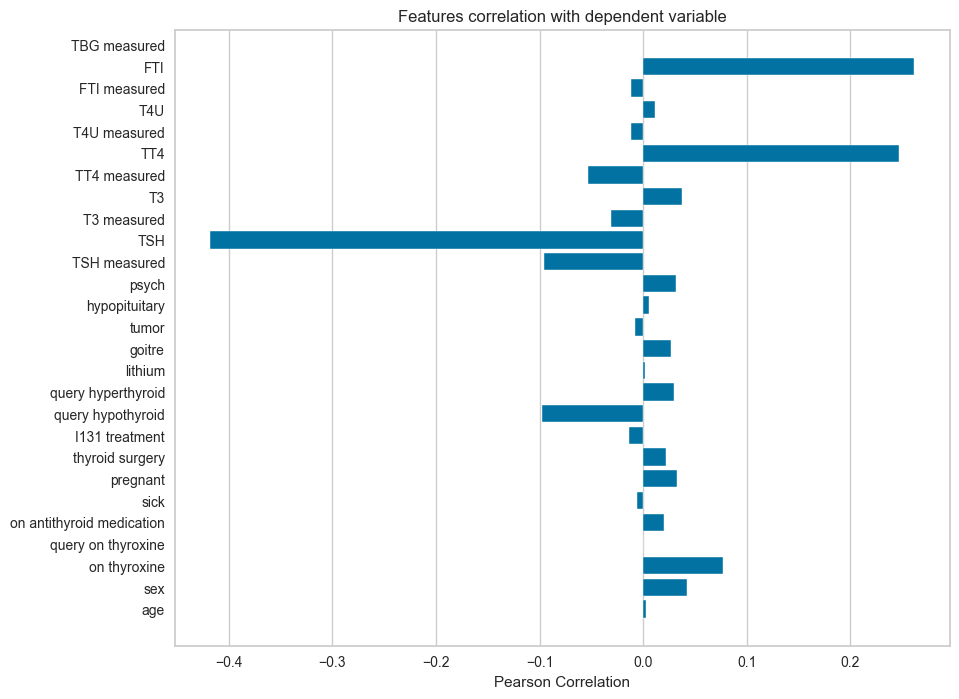

In [403]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train, y_train, labels=list(X_train.columns),method='pearson');

In [404]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [405]:
pca = PCA().fit(X_train);

Text(0.5, 1.0, 'Porcentaje de variancia explicada por componente')

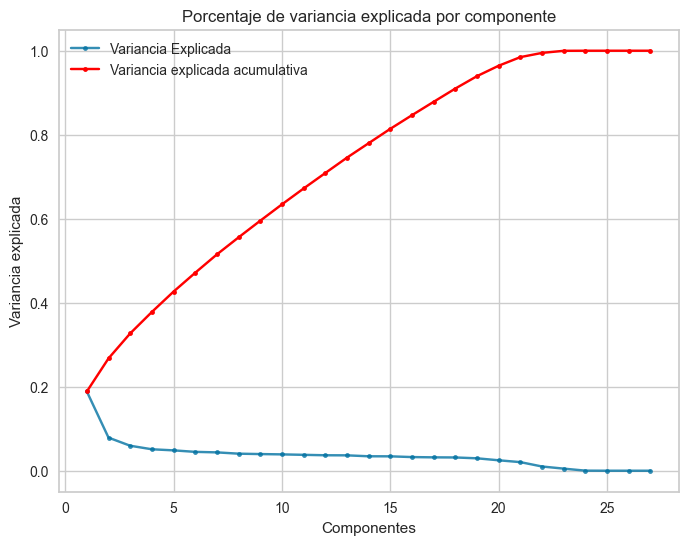

In [406]:
fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada")
y_label = plt.ylabel('Variancia explicada')
x_label = plt.xlabel('Componentes')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa")
plt.legend()
plt.title('Porcentaje de variancia explicada por componente')

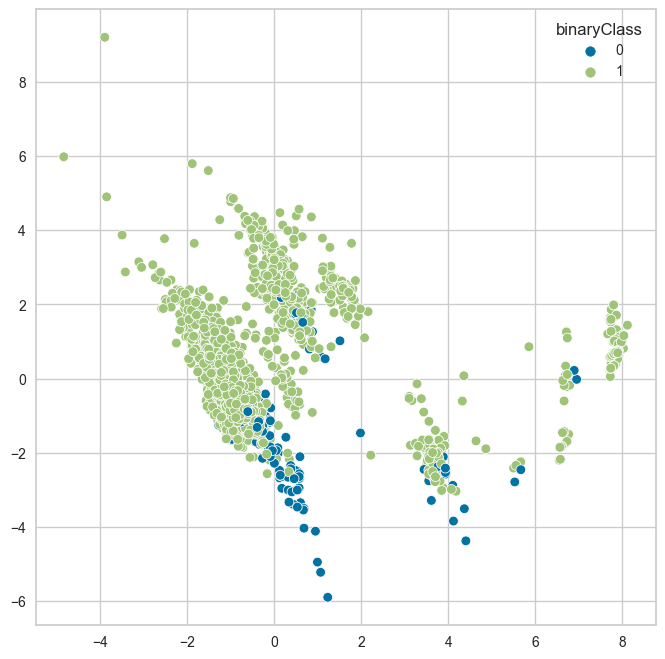

In [407]:
X_trans = pca.transform(X_train)
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

In [2]:
from sklearn.manifold import TSNE

X_trans = TSNE(n_components=2, perplexity=10,n_iter=10000, init='pca').fit_transform(X_train)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

NameError: name 'X_train' is not defined

In [409]:
lda = LinearDiscriminantAnalysis()

param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]}

lda_gs =  GridSearchCV(lda,param_grid,cv=10, n_jobs=-1, refit=True)
lda_gs.fit(X_train, y_train)

print(np.mean(cross_val_score(lda_gs,X_train,y_train,cv=10)))

/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 445, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/home/pol/.l

GridSearchCV(cv=10, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
                         'solver': ['svd', 'lsqr', 'eigen']})

/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 445, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/home/pol/.l

0.944626080834305


/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 445, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/home/pol/.l

In [410]:
print(classification_report(lda_gs.predict(X_test), y_test,target_names=['P', 'N']))
results_df = save_results(lda_gs, X_test, y_test, 'LDA', results_df)

              precision    recall  f1-score   support

           P       0.26      1.00      0.41        15
           N       1.00      0.94      0.97       740

    accuracy                           0.94       755
   macro avg       0.63      0.97      0.69       755
weighted avg       0.99      0.94      0.96       755



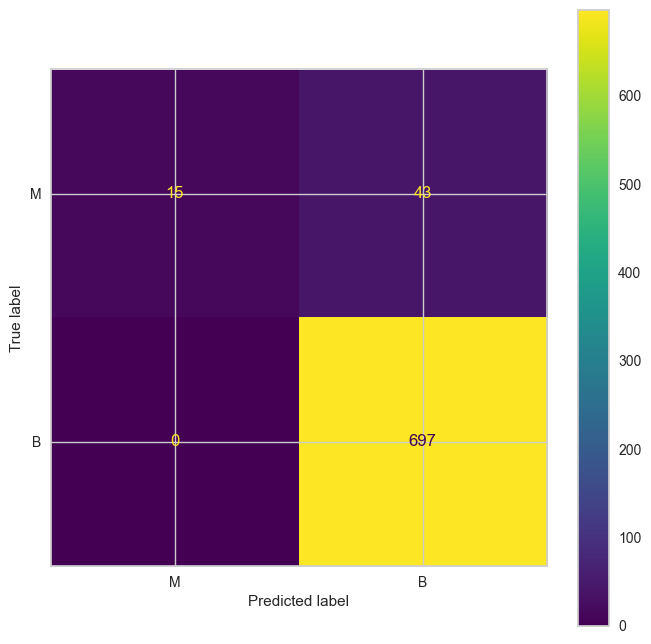

In [411]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lda_gs, X_test,y_test, display_labels=['M', 'B'], ax=plt.subplot());

In [3]:
plt.figure(figsize=(8,8));
roc_auc(lda_gs, X_train, y_train, X_test, y_test, classes=clases);

NameError: name 'plt' is not defined

/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 445, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/home/pol/.l

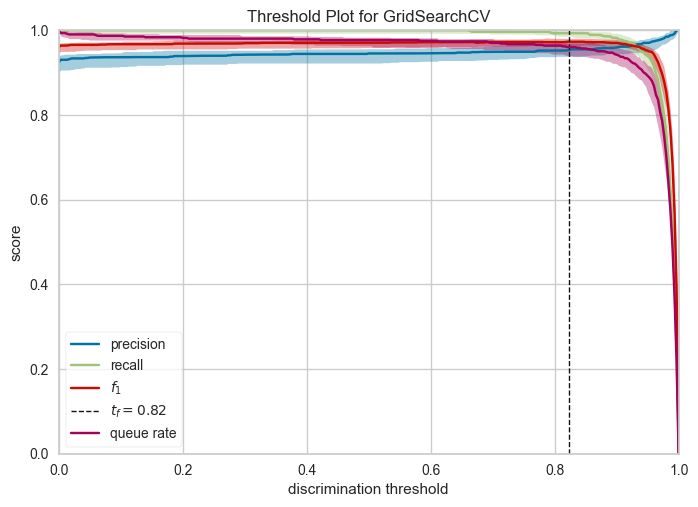

In [414]:
discrimination_threshold(lda_gs, X_train, y_train, is_fitted=True);

### QDA

In [415]:
qda = QuadraticDiscriminantAnalysis()
print(np.mean(cross_val_score(qda,X_train,y_train,cv=10)))

0.2012606983344701


/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local

In [416]:
param = {'reg_param':np.linspace(0,1,21, endpoint=True)}
qda_gs =  GridSearchCV(qda,param,cv=10, n_jobs=-1, refit=True)
qda_gs.fit(X_train, y_train);

/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/pol/.local

In [417]:
show_html(pd.DataFrame(qda_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
19,{'reg_param': 0.9500000000000001},0.945948,1
20,{'reg_param': 1.0},0.944957,2
18,{'reg_param': 0.9},0.942302,3
17,{'reg_param': 0.8500000000000001},0.938986,4
16,{'reg_param': 0.8},0.933020,5


In [418]:
print(classification_report(qda_gs.predict(X_test), y_test,target_names=['P', 'N']))
results_df = save_results(qda_gs, X_test, y_test, 'QDA', results_df)


              precision    recall  f1-score   support

           P       0.26      1.00      0.41        15
           N       1.00      0.94      0.97       740

    accuracy                           0.94       755
   macro avg       0.63      0.97      0.69       755
weighted avg       0.99      0.94      0.96       755



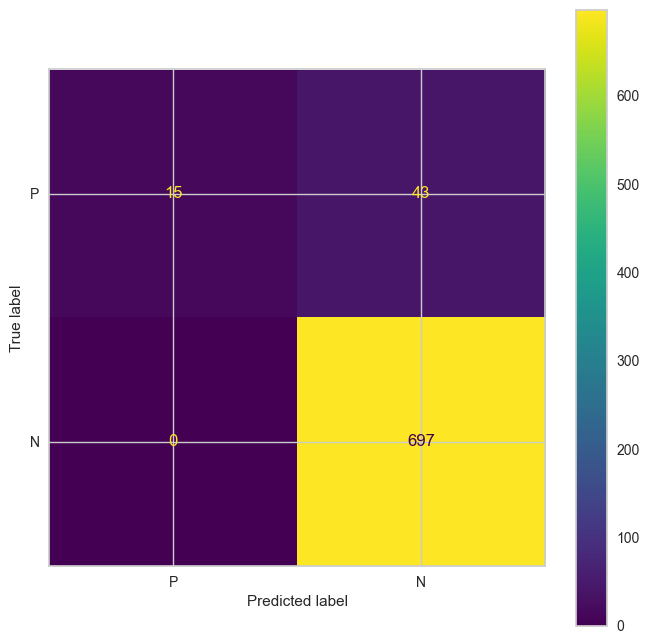

In [419]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(qda_gs, X_test,y_test, display_labels=['P', 'N'], ax=plt.subplot());

### REGRESIÓN LOGÍSTICA

In [420]:
lr = LogisticRegression(max_iter=1000)
print(np.mean(cross_val_score(lr,X_train,y_train,cv=10)))

0.9631944291654749


In [421]:
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-4,4,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train, y_train);

/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
210 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/pol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 61, in _check_solver
    raise Va

In [422]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
33,"{'C': 251.18864315095823, 'penalty': 'l2'}",0.974801,1
35,"{'C': 630.9573444801943, 'penalty': 'l2'}",0.974801,1
29,"{'C': 39.81071705534978, 'penalty': 'l2'}",0.974470,3
31,"{'C': 100.0, 'penalty': 'l2'}",0.974470,3
41,"{'C': 10000.0, 'penalty': 'l2'}",0.974138,5


In [423]:
print(classification_report(lr_gs.predict(X_test), y_test,target_names=['P', 'N']))
results_df = save_results(lr_gs, X_test, y_test, 'Linear regression', results_df)


              precision    recall  f1-score   support

           P       0.69      0.93      0.79        43
           N       1.00      0.97      0.99       712

    accuracy                           0.97       755
   macro avg       0.84      0.95      0.89       755
weighted avg       0.98      0.97      0.97       755



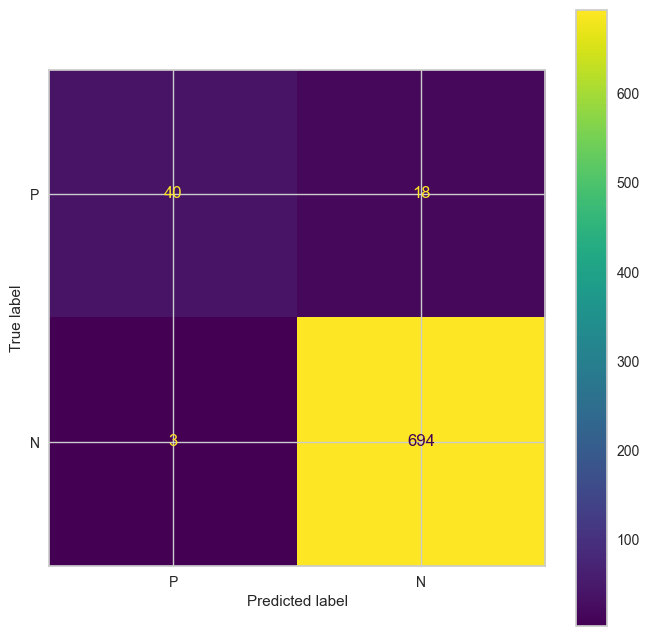

In [424]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,y_test, display_labels=['P', 'N'], ax=plt.subplot());

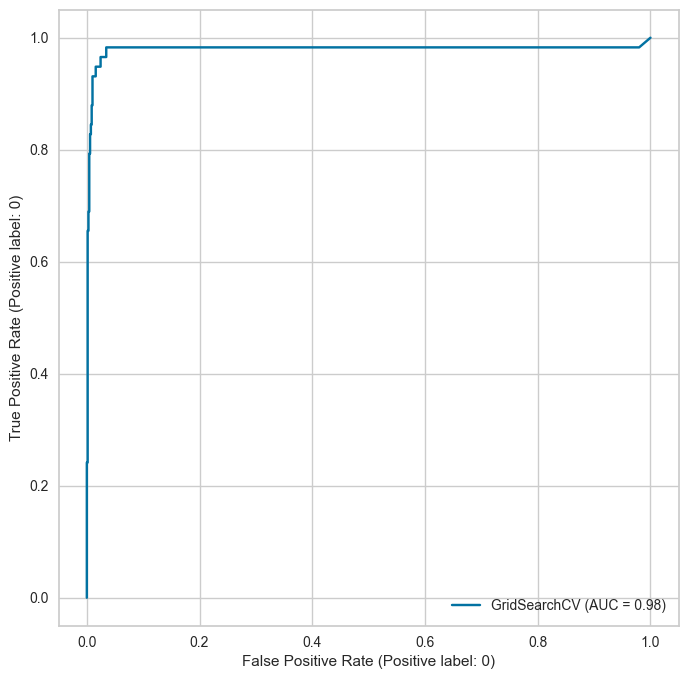

In [425]:
plt.figure(figsize=(8,8))
RocCurveDisplay.from_estimator(lr_gs, X_test,y_test, pos_label=0, ax=plt.subplot());

### NAÏVE  BAYES

In [441]:
gnb = GaussianNB()
print(np.mean(cross_val_score(gnb,X_train,y_train,cv=10)))

gnb_model = GaussianNB().fit(X_train, y_train)

0.21353215550812968


Este bajo valor de precisión que nos devuelve Naïve Bayes lo atribuyo principalmente a la hora que hemos decidido tratar con los valores NaN que reciben las classes que más peso/correlación tiene en la classificación del hipotiroidismo, puesto que hemos decidido sustituirlos con el valor de su mediana. Además de tratar con los valores desconocidos de la clase 'sex' que hemos decidido clasificarlos con el sexo de mujeres ya que la clase con más instancias con este valor era precisamente el femenino, con etiqueta F.

##### 1ero argumento

df_test['TSH'].fillna(value=df_test['TSH'].mean(), inplace = True) <br>
df_test['T3'].fillna(value=df_test['age'].mean(), inplace = True)  <br>
df_test['TT4'].fillna(value=df_test['age'].mean(), inplace = True) <br>
df_test['T4U'].fillna(value=df_test['age'].mean(), inplace = True) <br> 
df_test['FTI'].fillna(value=df_test['age'].mean(), inplace = True) <br>

##### 2ndo argumento

df_train.replace(to_replace='?', inplace=True, value='F') <br>
df_train['sex'] = df_train['sex'].astype('category').cat.codes <br>

In [442]:
print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
# means.columns=X_train.columns
# means

Priors: [0.07725464 0.92274536]
Means:



In [443]:
print(classification_report(gnb_model.predict(X_test), y_test,target_names=['P', 'N']))
results_df = save_results(gnb_model, X_test, y_test, 'Naïve Bayes', results_df)


              precision    recall  f1-score   support

           P       0.98      0.09      0.16       641
           N       0.16      0.99      0.28       114

    accuracy                           0.23       755
   macro avg       0.57      0.54      0.22       755
weighted avg       0.86      0.23      0.18       755



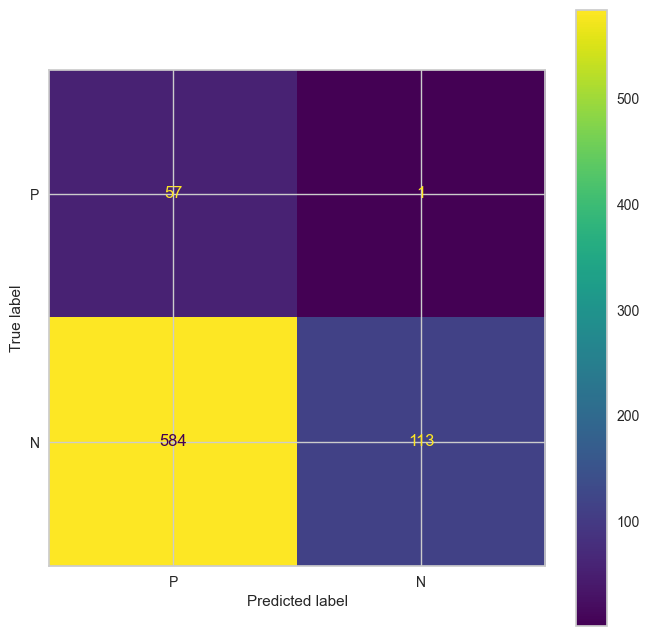

In [444]:

plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, display_labels=['P', 'N'], ax=plt.subplot());

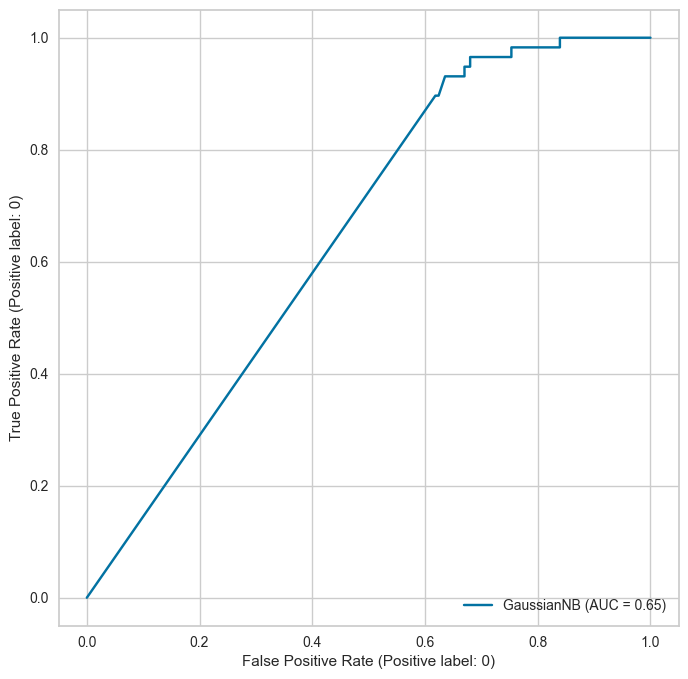

In [445]:
plt.figure(figsize=(8,8))

RocCurveDisplay.from_estimator(gnb_model, X_test,y_test, pos_label=0, ax=plt.subplot());

### KNN

In [446]:
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [447]:
knn =  KNeighborsClassifier()
print(np.mean(cross_val_score(knn,X_train_s,y_train,cv=10)))

0.9343501793139867


In [448]:
param = {'n_neighbors':[1, 2, 3, 4, 5, 7, 9, 11, 13, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=10, n_jobs=-1)
knn_gs.fit(X_train_s, y_train);

In [449]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
147,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 4, 'weights': 'uniform'}",0.942306,1
207,"{'leaf_size': 20, 'metric': 'l1', 'n_neighbors': 4, 'weights': 'uniform'}",0.942306,1
27,"{'leaf_size': 1, 'metric': 'l1', 'n_neighbors': 4, 'weights': 'uniform'}",0.942306,1
267,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 4, 'weights': 'uniform'}",0.942306,1
87,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 4, 'weights': 'uniform'}",0.942306,1


In [450]:
print(classification_report(knn_gs.predict(X_test_s), y_test,target_names=['P', 'N']))
results_df = save_results(knn_gs, X_test, y_test, 'KNN', results_df)


              precision    recall  f1-score   support

           P       0.31      0.62      0.41        29
           N       0.98      0.94      0.96       726

    accuracy                           0.93       755
   macro avg       0.65      0.78      0.69       755
weighted avg       0.96      0.93      0.94       755



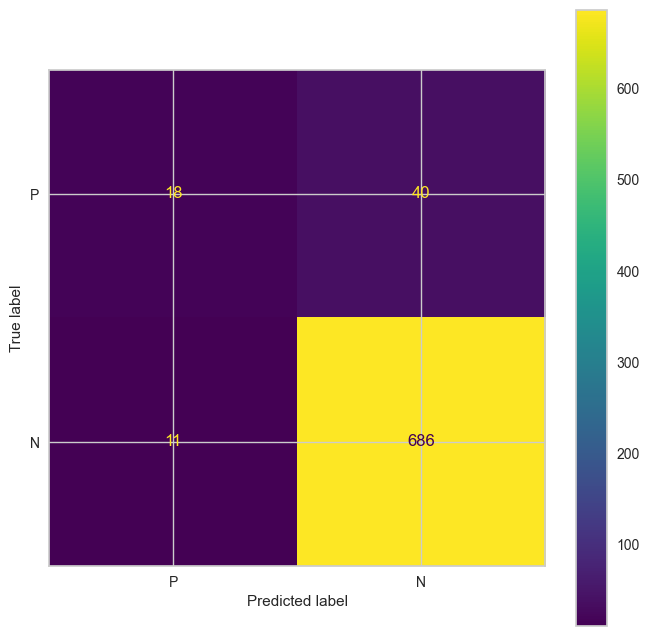

In [451]:
cls = ['P', 'N']
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_s,y_test, display_labels=cls, ax=plt.subplot());

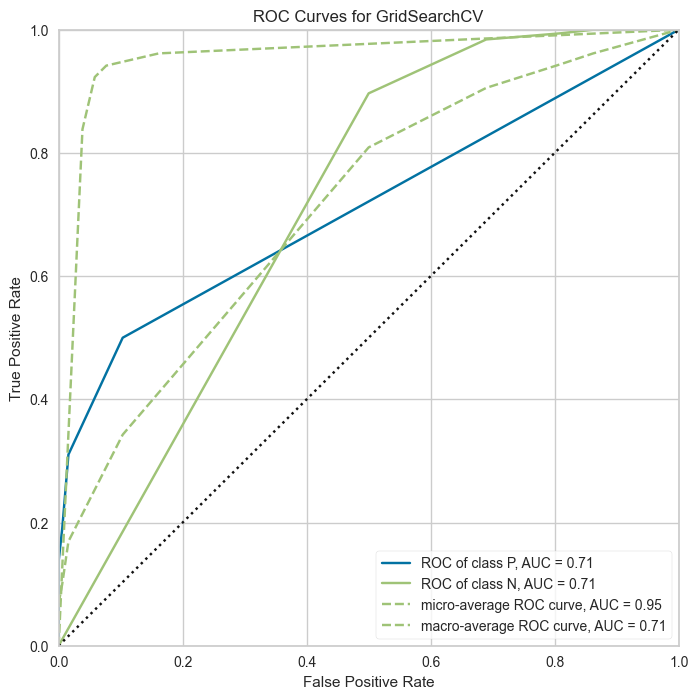

In [452]:

plt.figure(figsize=(8,8))
roc_auc(knn_gs, X_train_s, y_train, X_test_s, y_test, classes=cls);

In [453]:
# c = choice(X_test.shape[0], size=100, replace=False)
# pi = permutation_importance(knn_gs,X_test_s[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
# var_imp = pd.DataFrame({'importance': pi.importances_mean}, index=X_train.columns[:])

In [454]:
# var_imp.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

### MLP

In [455]:
#Conseguimos el csv de entrenamiento
# X_train = read_csv('df_train.csv')
# y_train = X_train['binaryClass']
#
# X_train.drop('binaryClass', axis=1, inplace = True)
#
# # X_train
# # y_train
#
# #Conseguimos el csv de test
# X_test = read_csv('df_test.csv')
# y_test = X_test['binaryClass']
#
# X_test.drop('binaryClass', axis=1, inplace = True)

# X_test
# y_test

In [456]:
sdscaler = StandardScaler()

X_train_sd = sdscaler.fit_transform(X_train)
X_test_sd = sdscaler.transform(X_test)

In [457]:
mlp = MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=15, random_state=42)
print(np.mean(cross_val_score(mlp,X_train_sd,y_train,cv=10)))

0.9469505621438472


In [458]:
param = {'hidden_layer_sizes':[10, 50, 100, 200],
         'activation':['relu', 'logistic', 'identity'], 
         'learning_rate_init': [0.001, 0.01, 0.1]  }

mlp =  MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=20,learning_rate='adaptive',random_state=42)
mlp_gs =  GridSearchCV(mlp,param,cv=10, n_jobs=-1, refit=True)
mlp_gs.fit(X_train_sd, y_train);

In [459]:
show_html(pd.DataFrame(mlp_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,"{'activation': 'relu', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}",0.986073,1
8,"{'activation': 'relu', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.1}",0.984417,2
23,"{'activation': 'logistic', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.1}",0.984084,3
10,"{'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.01}",0.983753,4
4,"{'activation': 'relu', 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.983089,5


In [460]:
param = {'hidden_layer_sizes':[10, 50, 100, 200, 300],
'activation':['relu', 'identity', 'logistic'], 
'alpha':[0.0001, 0.001, 0.01],
'momentum': [0.95, 0.90, 0.85, 0.8], 
'learning_rate_init': [0.001, 0.01, 0.1],
'n_iter_no_change':[10, 20, 40, 50], 
'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
mlp_bs =  BayesSearchCV(mlp,param,
                        n_iter=15, 
                        cv=10, n_jobs=-1, 
                        refit=True,random_state=0)
mlp_bs.fit(X_train_sd, y_train);

In [461]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 300, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.8, 'n_iter_no_change': 40}",0.982757,1
5,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'momentum': 0.85, 'n_iter_no_change': 50}",0.982092,2
13,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'momentum': 0.85, 'n_iter_no_change': 40}",0.981764,3
14,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'momentum': 0.8, 'n_iter_no_change': 20}",0.981762,4
0,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'momentum': 0.95, 'n_iter_no_change': 10}",0.980764,5


In [462]:
print(classification_report(mlp_gs.predict(X_test_sd), y_test,target_names=cls))
results_df = save_results(mlp_gs, X_test, y_test, 'MLP', results_df)


              precision    recall  f1-score   support

           P       0.95      0.93      0.94        59
           N       0.99      1.00      0.99       696

    accuracy                           0.99       755
   macro avg       0.97      0.96      0.97       755
weighted avg       0.99      0.99      0.99       755



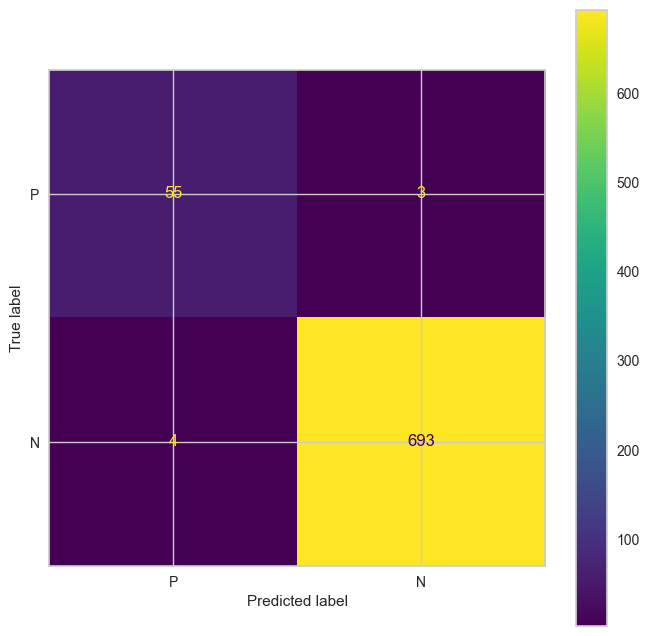

In [463]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(mlp_gs, X_test_sd,y_test, display_labels=cls, ax=plt.subplot());

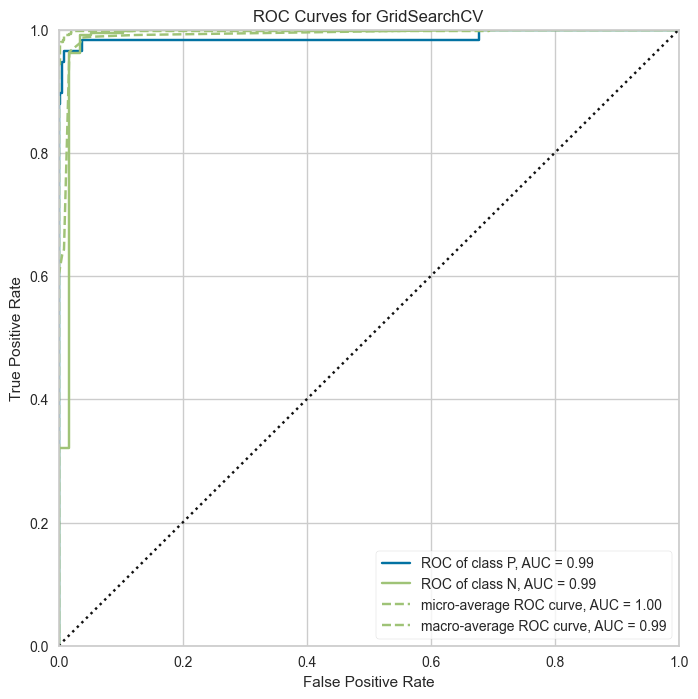

In [464]:
plt.figure(figsize=(8,8))
roc_auc(mlp_gs, X_train_sd, y_train, X_test_sd, y_test, classes=cls);


In [465]:
# c = choice(X_test.shape[0], size=100, replace=False)
# pi = permutation_importance(mlp_bs,X_test_sd[c], y_test.to_numpy()[c], n_jobs=-1, random_state=42)
# var_imp = pd.DataFrame({'importance': pi.importances_mean},
#                        index=X_train.columns[:])

In [466]:
# var_imp.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

In [467]:
print(classification_report(mlp_bs.predict(X_test_sd), y_test,target_names=cls))
results_df = save_results(mlp_bs, X_test, y_test, 'MLP BS', results_df)


              precision    recall  f1-score   support

           P       0.90      0.95      0.92        55
           N       1.00      0.99      0.99       700

    accuracy                           0.99       755
   macro avg       0.95      0.97      0.96       755
weighted avg       0.99      0.99      0.99       755



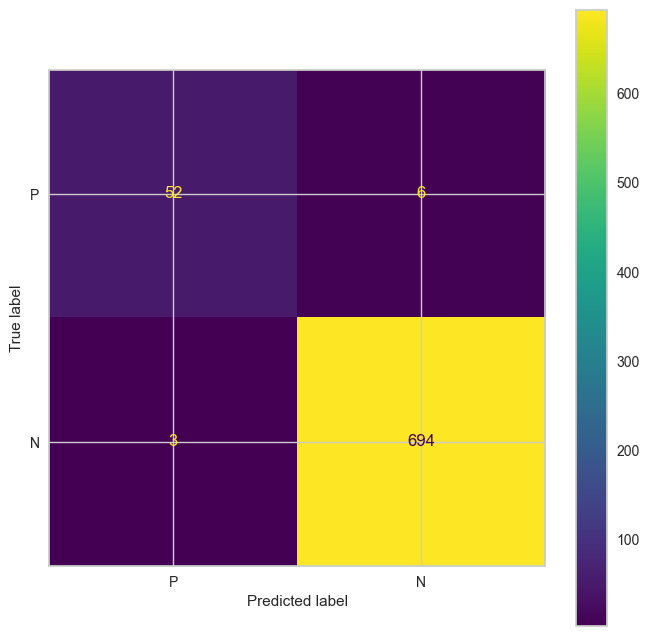

In [468]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test_sd,y_test, display_labels=cls, ax=plt.subplot());

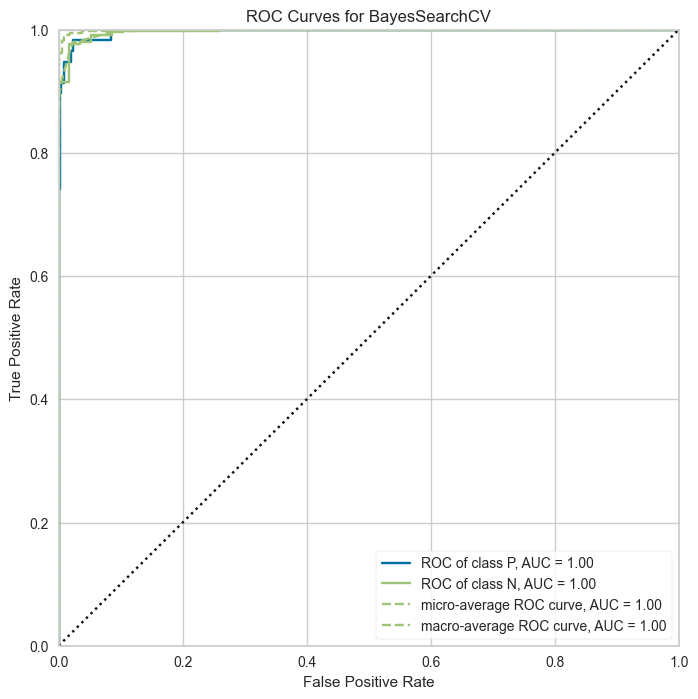

In [469]:
plt.figure(figsize=(8,8))
roc_auc(mlp_bs, X_train_sd, y_train, X_test_sd, y_test, classes=cls);

In [470]:
# c = choice(X_test.shape[0], size=100, replace=False)
# pi = permutation_importance(mlp_bs,X_test_sd[c], y_test.to_numpy()[c], n_jobs=-1, random_state=42)
# var_imp = pd.DataFrame({'importance': pi.importances_mean},
#                        index=X_train.columns[:])

In [471]:
# var_imp.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

### SVM - lineal

In [472]:
# param = {'C':10**np.linspace(-4,4,101)}
param = {'C': [0.1, 1, 10, 100],
              'tol': [1e-3, 1e-4, 1e-5]}

lsvc =  SVC(kernel='linear', max_iter=25000, random_state=42)
lsvc_gs = BayesSearchCV(lsvc,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=42)
lsvc_gs.fit(X_train, y_train)

/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminate

BayesSearchCV(cv=5,
              estimator=SVC(kernel='linear', max_iter=25000, random_state=42),
              n_iter=15, n_jobs=-1, random_state=42,
              search_spaces={'C': [0.1, 1, 10, 100],
                             'tol': [0.001, 0.0001, 1e-05]})

In [473]:
show_html(pd.DataFrame(lsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
3,"{'C': 10.0, 'tol': 1e-05}",0.977121,1
4,"{'C': 10.0, 'tol': 0.0001}",0.977121,1
5,"{'C': 10.0, 'tol': 0.001}",0.977121,1
6,"{'C': 10.0, 'tol': 0.001}",0.977121,1
7,"{'C': 10.0, 'tol': 0.001}",0.977121,1


In [474]:
clases = [str(v) for v in sorted(np.unique(y_train))]
# clases

print(classification_report(lsvc_gs.predict(X_test), y_test,target_names=clases))
results_df = save_results(lsvc_gs, X_test, y_test, 'SVM Linear', results_df)


              precision    recall  f1-score   support

           0       0.78      0.94      0.85        48
           1       1.00      0.98      0.99       707

    accuracy                           0.98       755
   macro avg       0.89      0.96      0.92       755
weighted avg       0.98      0.98      0.98       755



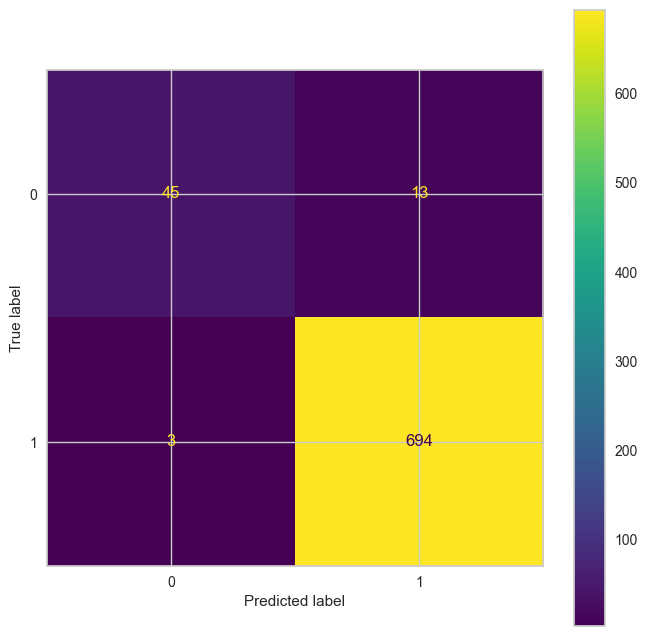

In [475]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lsvc_gs, X_test, y_test, display_labels=clases, ax=plt.subplot());

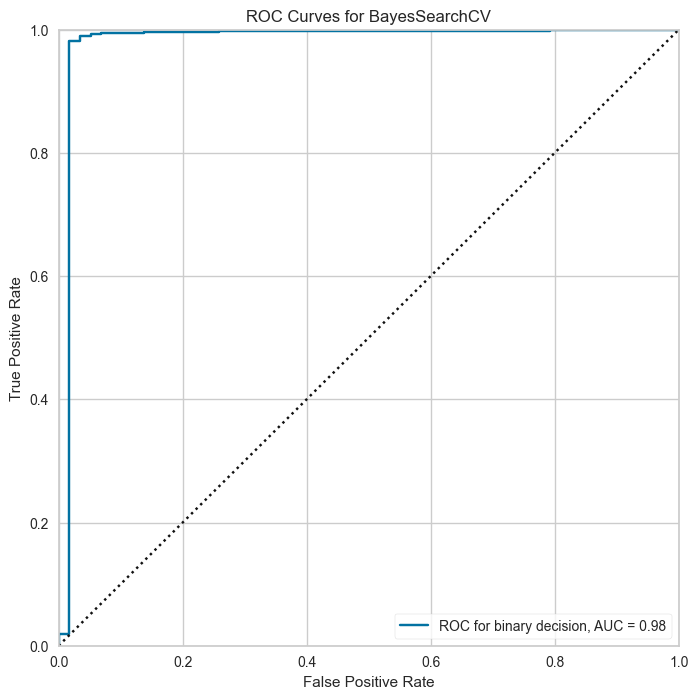

In [476]:
plt.figure(figsize=(8,8))
roc_auc(lsvc_gs, X_train, y_train, X_test, y_test, binary=True);

### SVM con kernel polinómico no-lineal

In [477]:
param = {'C':10**np.linspace(-4,4,101), 'degree':[2,3]}

psvc =  SVC(kernel='poly', max_iter=25000, random_state=0)
psvc_gs = BayesSearchCV(psvc,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
psvc_gs.fit(X_train, y_train);

/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminate

In [478]:
show_html(pd.DataFrame(psvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
6,"{'C': 5754.399373371566, 'degree': 3}",0.969165,1
13,"{'C': 10000.0, 'degree': 3}",0.968833,2
11,"{'C': 208.92961308540407, 'degree': 2}",0.963197,3
5,"{'C': 524.8074602497722, 'degree': 3}",0.961538,4
14,"{'C': 33.11311214825915, 'degree': 2}",0.951925,5


In [479]:
print(classification_report(psvc_gs.predict(X_test), y_test,target_names=clases))
results_df = save_results(psvc_gs, X_test, y_test, 'SVM polynomial', results_df)


              precision    recall  f1-score   support

           0       0.78      0.75      0.76        60
           1       0.98      0.98      0.98       695

    accuracy                           0.96       755
   macro avg       0.88      0.87      0.87       755
weighted avg       0.96      0.96      0.96       755



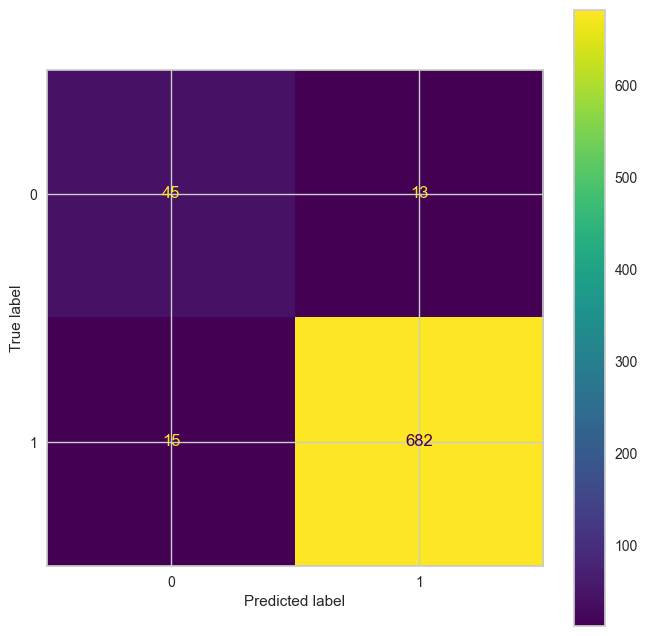

In [480]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(psvc_gs, X_test, y_test, display_labels=clases, ax=plt.subplot());

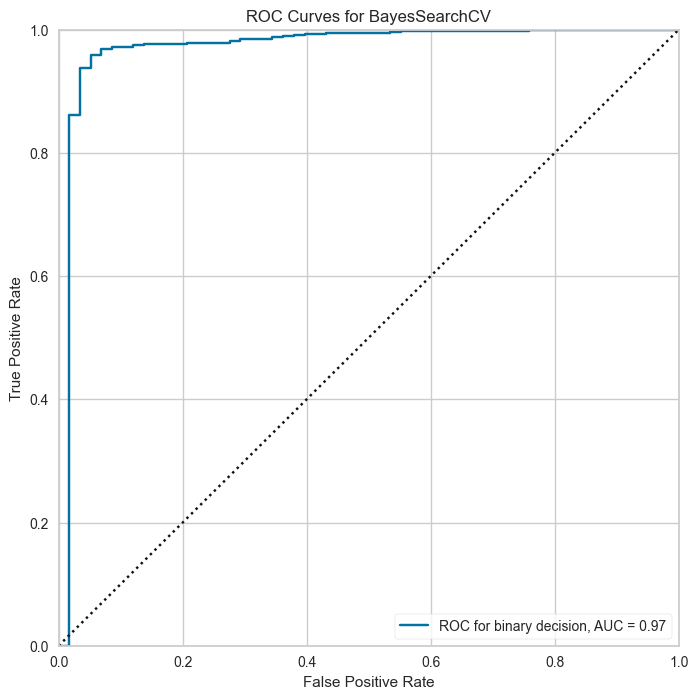

In [481]:
plt.figure(figsize=(8,8))
roc_auc(psvc_gs, X_train, y_train, X_test, y_test, binary=True);

### SVM con kernel rbf no-lineal

In [482]:
param = {'C':10**np.linspace(-4,4,101), 'gamma':['scale','auto']}

rbsvc =  SVC(kernel='rbf', max_iter=25000, random_state=0)
rbsvc_gs = BayesSearchCV(rbsvc,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=42)
rbsvc_gs.fit(X_train, y_train);

/home/pol/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [483]:
show_html(pd.DataFrame(rbsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
4,"{'C': 251.18864315095823, 'gamma': 'auto'}",0.979113,1
3,"{'C': 301.9951720402019, 'gamma': 'auto'}",0.978781,2
10,"{'C': 251.18864315095823, 'gamma': 'scale'}",0.978781,2
5,"{'C': 69.18309709189363, 'gamma': 'scale'}",0.977785,4
1,"{'C': 524.8074602497722, 'gamma': 'scale'}",0.977785,5


In [484]:
print(classification_report(rbsvc_gs.predict(X_test), y_test,target_names=clases))
results_df = save_results(rbsvc_gs, X_test, y_test, 'SVM RBF', results_df)


              precision    recall  f1-score   support

           0       0.78      0.88      0.83        51
           1       0.99      0.98      0.99       704

    accuracy                           0.97       755
   macro avg       0.88      0.93      0.91       755
weighted avg       0.98      0.97      0.98       755



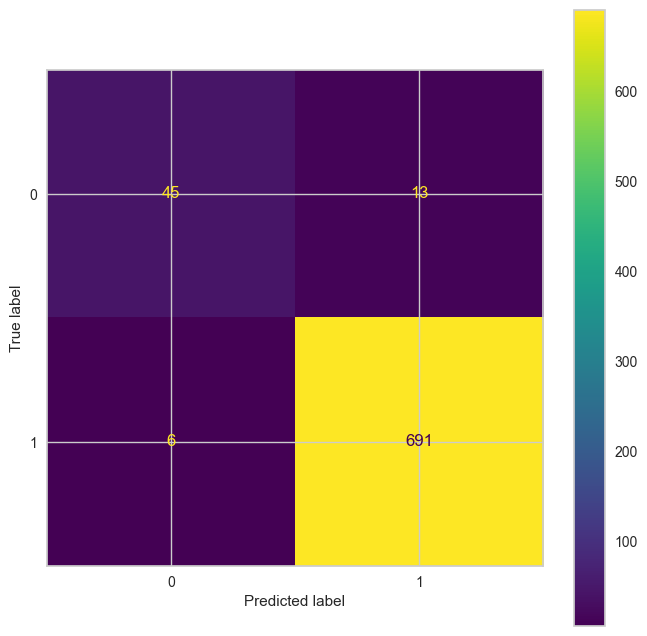

In [485]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(rbsvc_gs, X_test, y_test, display_labels=clases, ax=plt.subplot());

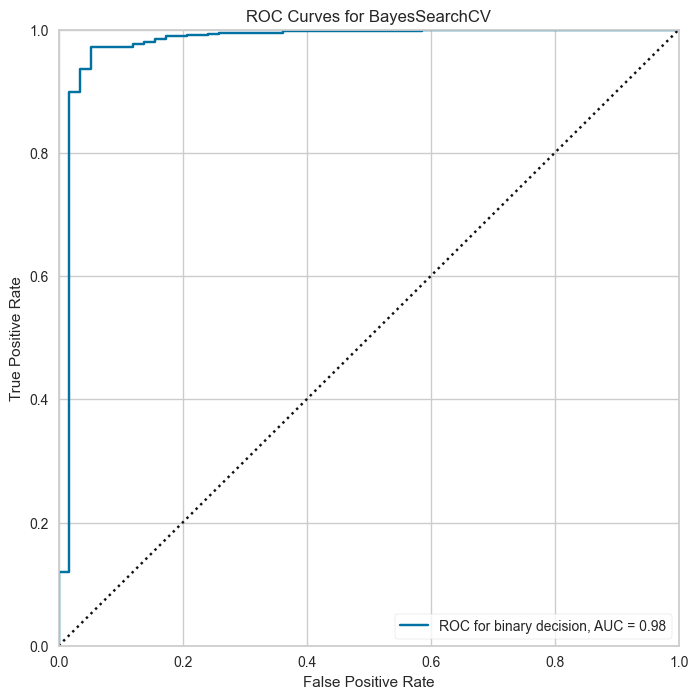

In [486]:
plt.figure(figsize=(8,8))
roc_auc(rbsvc_gs, X_train, y_train, X_test, y_test, binary=True);

### Random Forest

In [487]:
rf = RandomForestClassifier(random_state=42)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 20000, num = 100)]

param = [{'n_estimators': n_estimators,
          'max_depth': list(range(0, 2000)), 
          'max_features': ['auto','sqrt','log2'], 
          'min_samples_split': list(range(0, 2000)), 
          'criterion': ['gini', 'entropy'],
         'bootstrap': [True,False]}]

rf.fit(X_train,y_train);

In [488]:
print(np.mean(cross_val_score(rf,X_train,y_train,cv=10)))
#0.9943642604123122

0.9943642604123122


In [489]:
print(classification_report(rf.predict(X_test), y_test,target_names=['P', 'N']))
results_df = save_results(rf, X_test, y_test, 'Random forest', results_df)


              precision    recall  f1-score   support

           P       0.97      0.98      0.97        57
           N       1.00      1.00      1.00       698

    accuracy                           1.00       755
   macro avg       0.98      0.99      0.99       755
weighted avg       1.00      1.00      1.00       755



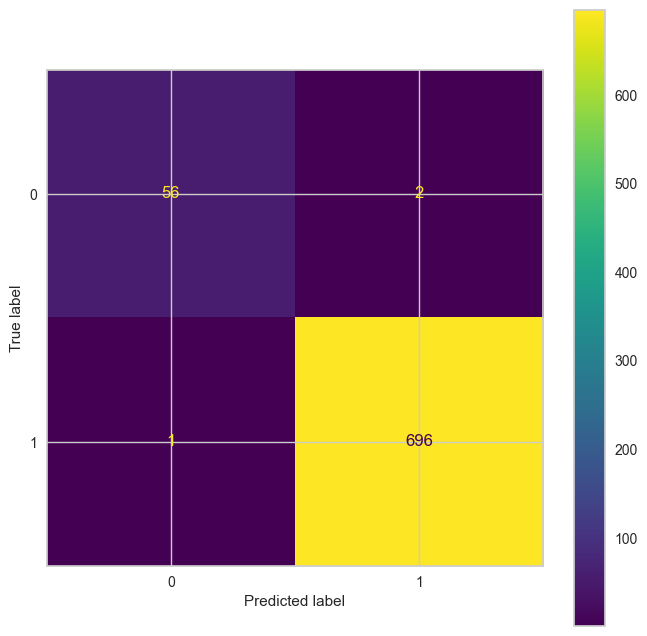

In [490]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=clases, ax=plt.subplot());

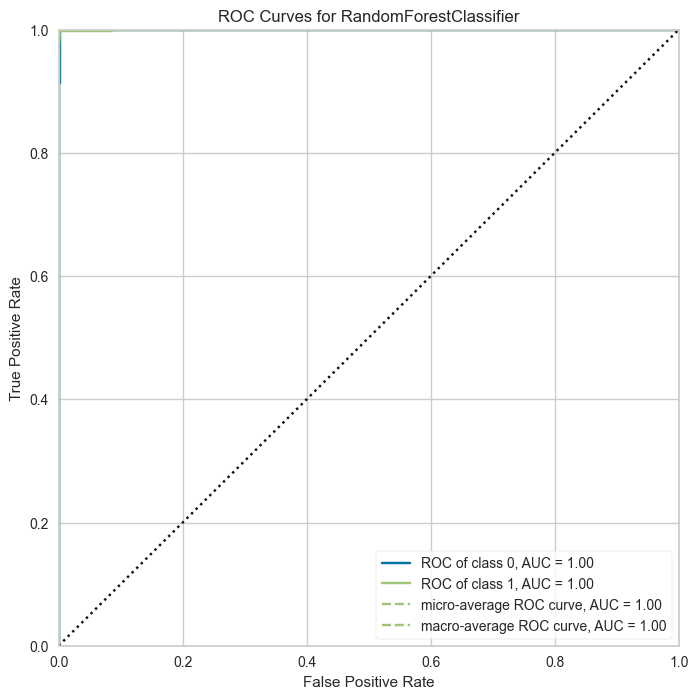

In [491]:
plt.figure(figsize=(8,8))
roc_auc(rf, X_train, y_train, X_test, y_test);

In [492]:
results_df.sort_values(by=['test acc'], ascending=False)

,test acc,test f1 score (0),test f1 score (1),test f1 score (W)
Random forest,0.996026,0.973913,0.997849,0.985881
MLP,0.990728,0.940171,0.994975,0.967573
MLP BS,0.988079,0.920354,0.993558,0.956956
SVM Linear,0.978808,0.849057,0.988604,0.918830
SVM RBF,0.974834,0.825688,0.986438,0.906063
Linear regression,0.972185,0.792079,0.985096,0.888588
SVM polynomial,0.962914,0.762712,0.979885,0.871298
LDA,0.943046,0.410959,0.970077,0.690518
QDA,0.943046,0.410959,0.970077,0.690518
KNN,0.931126,0.480000,0.963121,0.721560
